# Tutorial 3 : Training Spiking Neural Networks using BPTT

**AMLD EPFL 2022**: Spiking Neural Networks for Low-Power Real-Time Inference

**By SynSense**: Ugurcan Cakal, Hannah Bos, Saeid Haghighatshoar

**Estimated timing**: 30 minutes

So far we have investigated the Leaky Integrate and Fire (LIF) neuron model, and trained a Convolutional Neural Network (CNN) on a body posture classification task to be converted into an Spiking Neural Network (SNN). In this tutorial we will question 

* How to build an SNN using Rockpool implementation of torch-backend LIF model namely `LIFTorch`
* How to optimize parameters of SNNs directly using Back Propagation Through Time (BPTT)
* Why gradients vanish at spikes and how the problem can be alleviated using surrogate gradients

In this tutorial, a one-neuron SNN will be implemented and optimized to express a target spike firing rate.


TODOS :
* Fix multichannel operation of the readout

---
# Setup

In [1]:
# - Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Utils
import numpy as np
from tqdm import tqdm

# Torch Imports
import torch
from torch.nn import MSELoss
from torch.optim import Adam

# Rockpool Imports
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.modules.torch.lif_torch import StepPWL
from rockpool.nn.combinators import Sequential
from rockpool.parameters import Constant

# Tutorial Utils
from utils import plot_LIF_record, poisson_spike_train, RateReadout, plot_signal, plot_raster

# - Plotting and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

Could not import package: No module named 'iaf_nest'


### Data Generation

### Plotting

### Readout

---
## Section 1: Rockpool Modules

In this tutorial we will explore firing rate response of a spiking neural network. For this task, we will use 3 Rockpool modules with sequential combination. 

`LinearTorch`, `LIFTorch`, and `RateReadout`.

### LinearTorch
Linear layer stores the input weight matrix of the system. Applies a linear transformation to the incoming data. Then pass the results to the next layer.

* $S_{in}(t) = x \cdot W_{in} + b $

| **TERM**          | **DEFINITION**                                                                                        |
|------------------	|------------------------------------------------------------------------------------------------------	|
| $S_{in}(t)$      	| A vector containing $1$ (or a weighed spikes) for each input channel that emits a spike at time $t$ 	|
| $x$             	| external spiking input to the system                                                                	|
| $W_{in}$     	    | An input weight matrix                                                                             	|
| $b$     	        | linear bias                                                                                       	|

### LIFTorch
LIF layer calculates the neuron dynamics and produce a spike train output. This module implements the update equations below.

1. As first step it updates the synaptic current input $I_{syn}$
    * $I_{syn}(t+1) = \left( I_{syn}(t) + S_{in}(t) + \underbrace{S_{rec}(t) \cdot W_{rec}}_{I_{rec}} \right) \cdot \underbrace{\text{exp} \left( - \dfrac{dt}{\tau_{syn}} \right)}_{\text{leakage}} $

| **TERM**          | **DEFINITION**                                                                                        |
|------------------	|------------------------------------------------------------------------------------------------------	|
| $S_{rec}(t)$     	| A vector containing $1$ for each neuron that emitted a spike in the last time-step                   	|
| $W_{rec}$     	| A recurrent weight matrix                                                                          	|
| $dt$             	| discrete timestep                                                                                    	|
| $\tau_{syn}$     	| synaptic time constant                                                                               	|

* In our case, since we have not provided recurrent weights

    * $I_{syn}(t+1) = \left( I_{syn}(t) + S_{in}(t) \right) \cdot \text{exp} \left( - \dfrac{dt}{\tau_{syn}} \right) $

2. As a next step it calculates the membrane potential $V_{mem}$
    * $V_{mem}(t+1) = \left( V_{mem}(t) + I_{syn}(t) + I_b + \sigma \zeta(t) \right)  \cdot \text{exp} \left( - \dfrac{dt}{\tau_{mem}} \right)$

| **TERM**          | **DEFINITION**                                                                                        |
|------------------	|------------------------------------------------------------------------------------------------------	|
| $I_b$          	| bias current injection to the neruons                                             	                |
| $\sigma\zeta(t)$ 	| A Wiener noise process with standard deviation $\sigma$                                              	|
| $\tau_{mem}$     	| membrane time constant                                                                               	|


3. When the membrane potential for neuron $j$, $V_{mem, j}$ exceeds the threshold voltage $V_{thr}$, then the neuron emits a spike. The spiking neuron subtracts its own threshold on reset.

* $V_{mem, j} > V_{thr} \rightarrow S_{rec,j} = 1$
* $V_{mem, j} = V_{mem, j} - V_{thr}$

Neurons therefore share a common resting potential of $0$, have individual firing thresholds, and perform subtractive reset of $-V_{thr}$.

### RateReaout
Rate Readout layer is a custom `TorchModule` extension. It stands for measuring the firing rate of the given duration. Depending on the task, one can implement their own readout layer.

* $r = \dfrac{\sum_{t=0}^{T} S_{rec}}{T}$

| **TERM**          | **DEFINITION**                                                                                        |
|------------------	|------------------------------------------------------------------------------------------------------	|
| $r$ 	            | firing rates of the neuron                                                                            	|
| $T$           	| simulation duraiton                                                                                  	|

Below there is a diagram of the system visualising the sequential combination of the layers.

<img src="figures/network.png">

### Module Implementation

We will define a single neuron with single input channel. The rate readout layer is introduced to measure the mean firing rate of the spiking neuron throughout the simulation duration. The input weight, time constants, bias parameters and threshold are determined experimentaly to demonstrate the neuron's behavior properly.

In [28]:
dt = 1e-3

# --- Input Layer --- #
linear = LinearTorch(
    shape=(1, 1),
    weight=torch.tensor([[0.02]]),
    has_bias=False,
)

# --- LIF Layer --- #
lif = LIFTorch(
    shape=(1, 1),
    tau_mem=Constant(0.03),
    tau_syn=Constant(0.01),
    bias=Constant(0.0),
    threshold=Constant(1.0),
    spike_generation_fn=StepPWL,
    dt=dt,
)

# --- Readout Layer --- #
readout = RateReadout(shape=(1, 1), dt=dt)

# --- Model --- #
model = Sequential(linear, lif, readout)
model

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

### Generate a random spike train

In order to investigate the behaivor of the neuron, a poisson spike train is generated. 

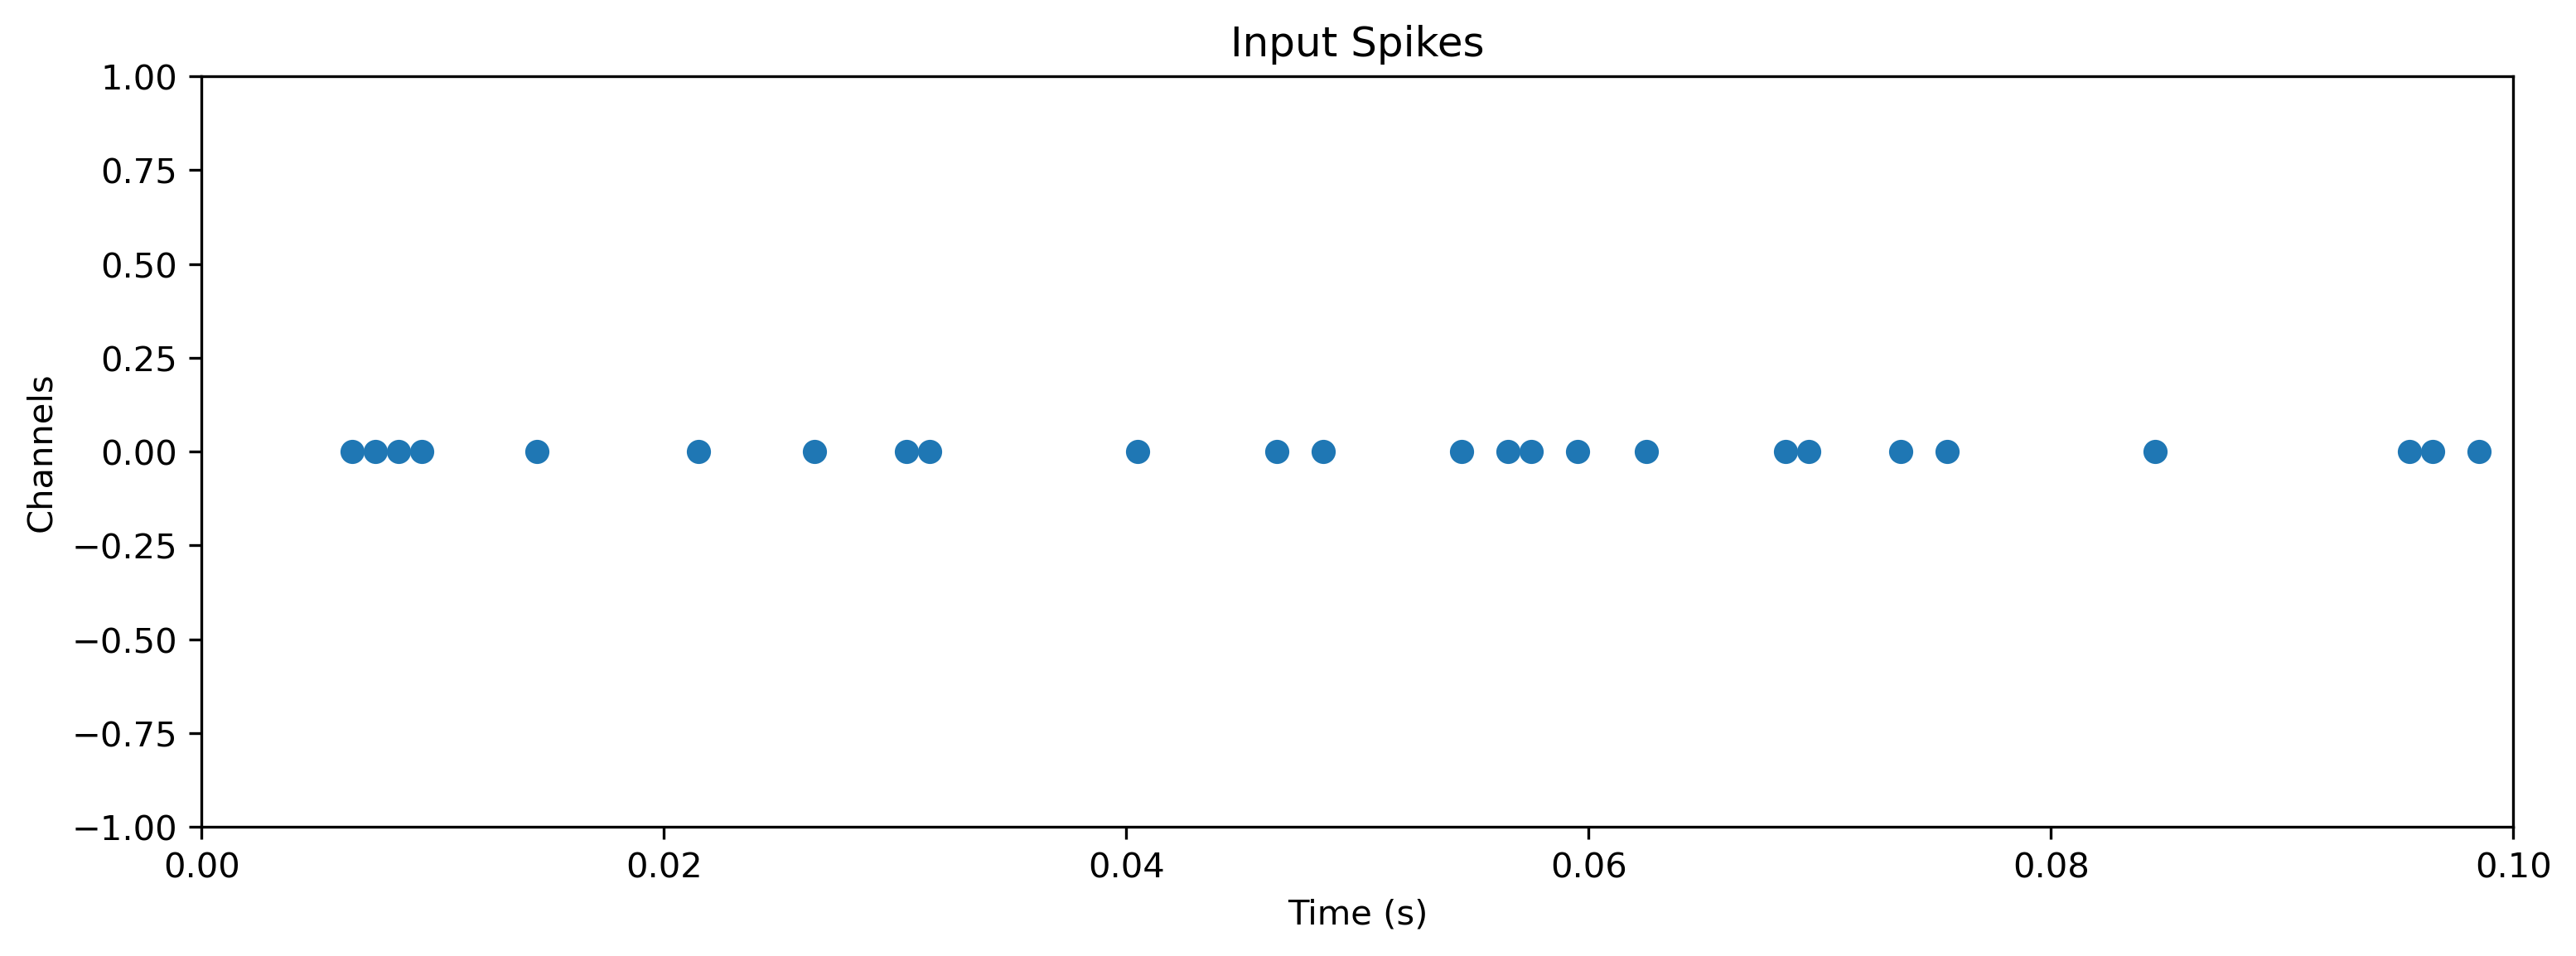

In [3]:
spike_ts = poisson_spike_train(duration=100e-3, rate=200.0, dt=dt, seed=2022)
plot_raster(spike_ts, "Input Spikes", dt)

### Simulate initial state of network

Simulating the untrained network with random spike train, we will observe the intermedite steps, the evolution of the membrane potential, and the resulting spiking output

In [4]:
model.reset_state()
rate_out, state, record_dict = model(spike_ts, record = True)

### Model Output

The output of the last layer, the firing rate of the neuron.

In [5]:
print("Mean firing rate:", rate_out.item(), "Hz")

Mean firing rate: 20.0 Hz


### Model State

Simulating the model for some duration, model state evolves. The `state` holds a dictionary of the last time step status of the state parameters of the stateful layers

In [6]:
print(state.keys())

dict_keys(['0_LinearTorch', '1_LIFTorch', '2_RateReadout'])


LinearTorch and RateReadout layers are stateless, only LIFTorch has some state parameters.

In [7]:
print(state["1_LIFTorch"])

{'vmem': tensor([0.5651]), 'isyn': tensor([[0.0525]]), 'spikes': tensor([0.])}


## Intermediate Steps

Let's plot the input once again, and check out the output of each layer passing through the next layer.

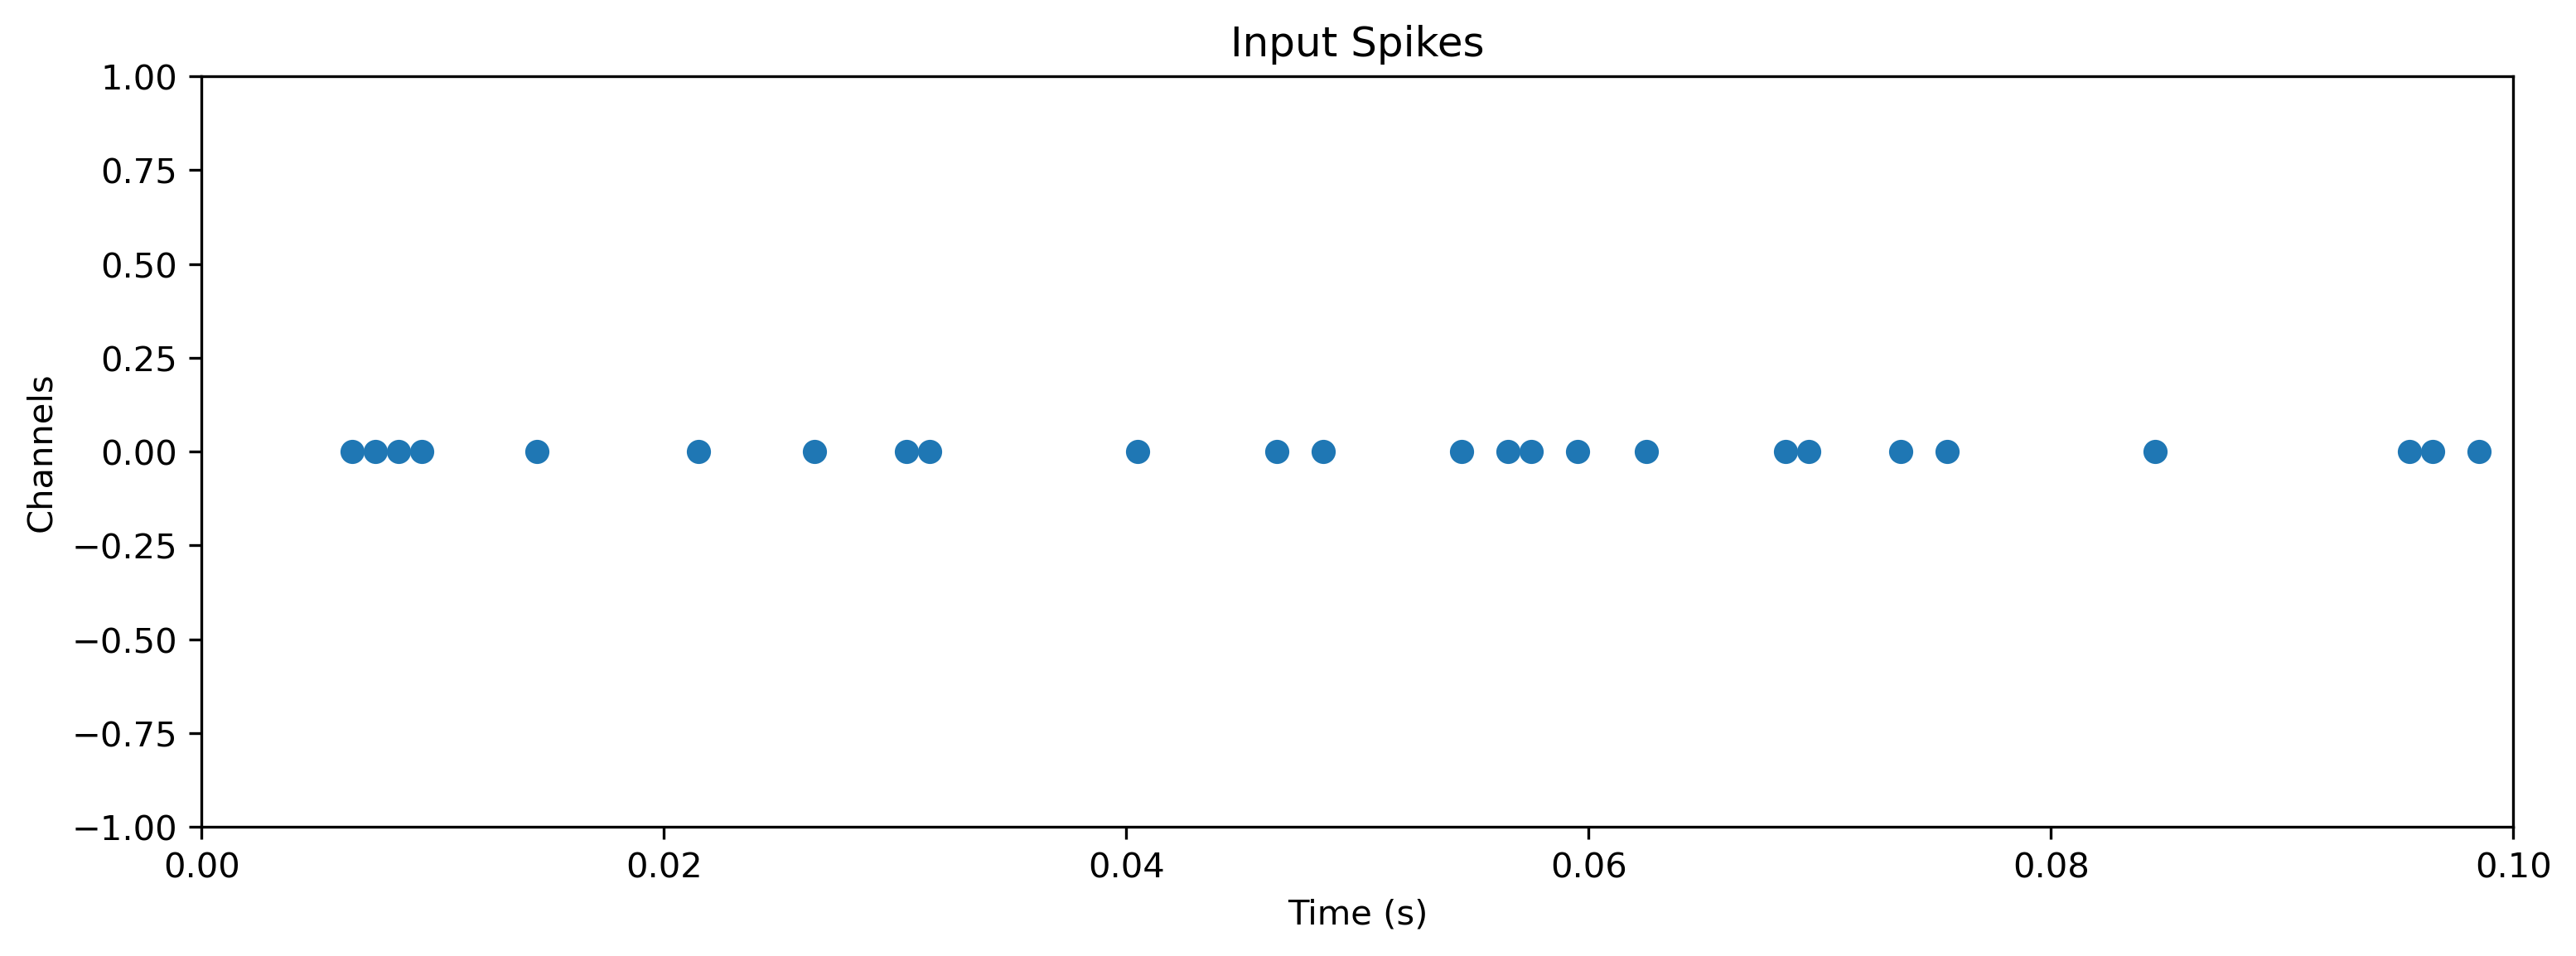

In [8]:
plot_raster(spike_ts, "Input Spikes", dt)

Input layer makes a linear transformation of the spike train. In our case:

$S_{in}(t) = x \cdot \underbrace{W_{in}}_{0.2} + \underbrace{b}_{0} $

$S_{in}(t) = 0.2x $


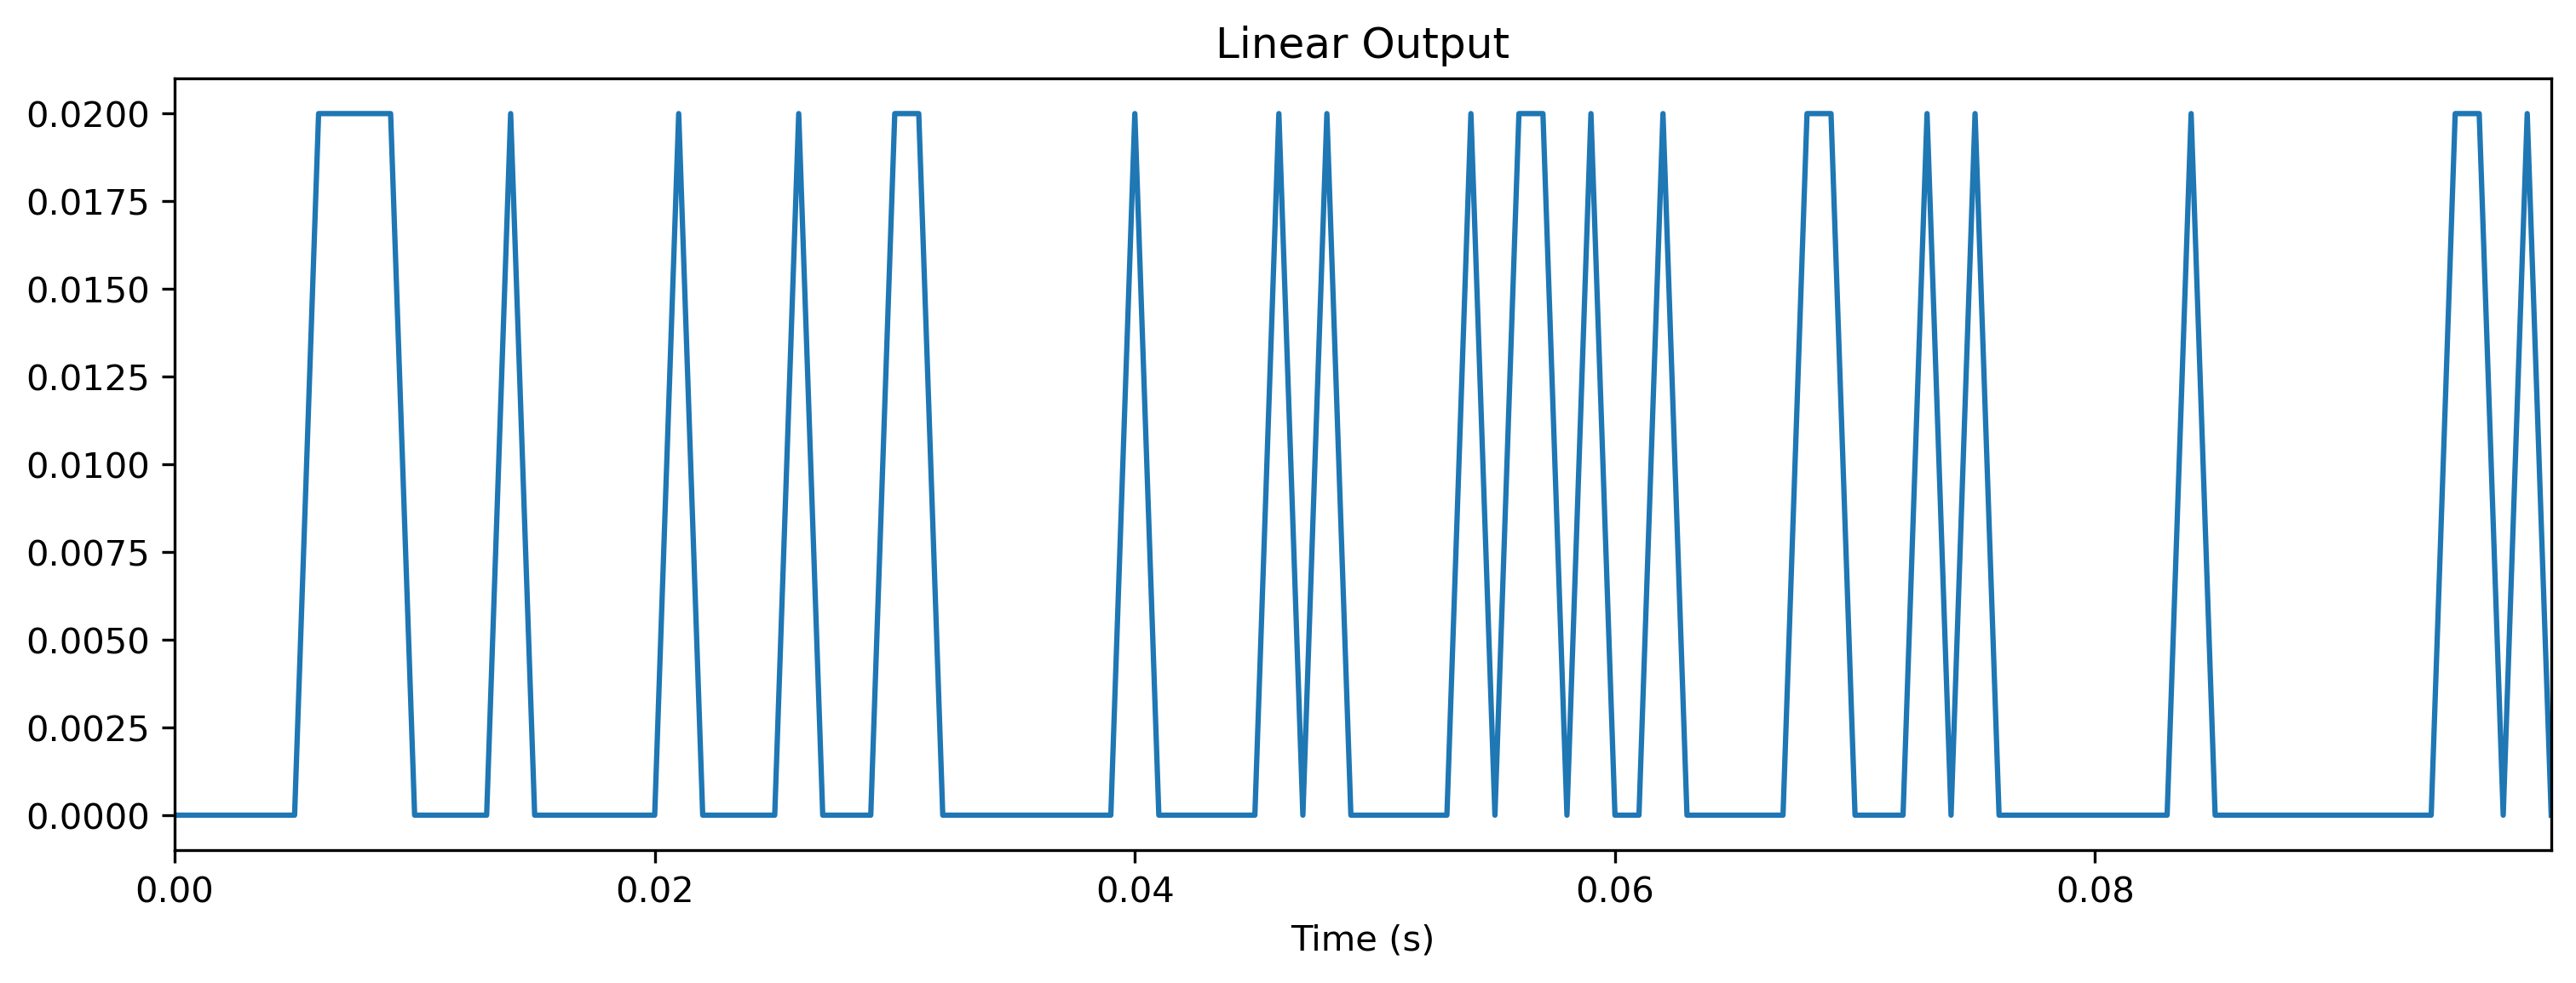

In [9]:
plot_signal(record_dict["0_LinearTorch_output"], "Linear Output", "", dt)

LIF layer computes the dynamics

In [10]:
record_dict["1_LIFTorch"].keys()

dict_keys(['vmem', 'isyn', 'spikes', 'irec', 'U'])

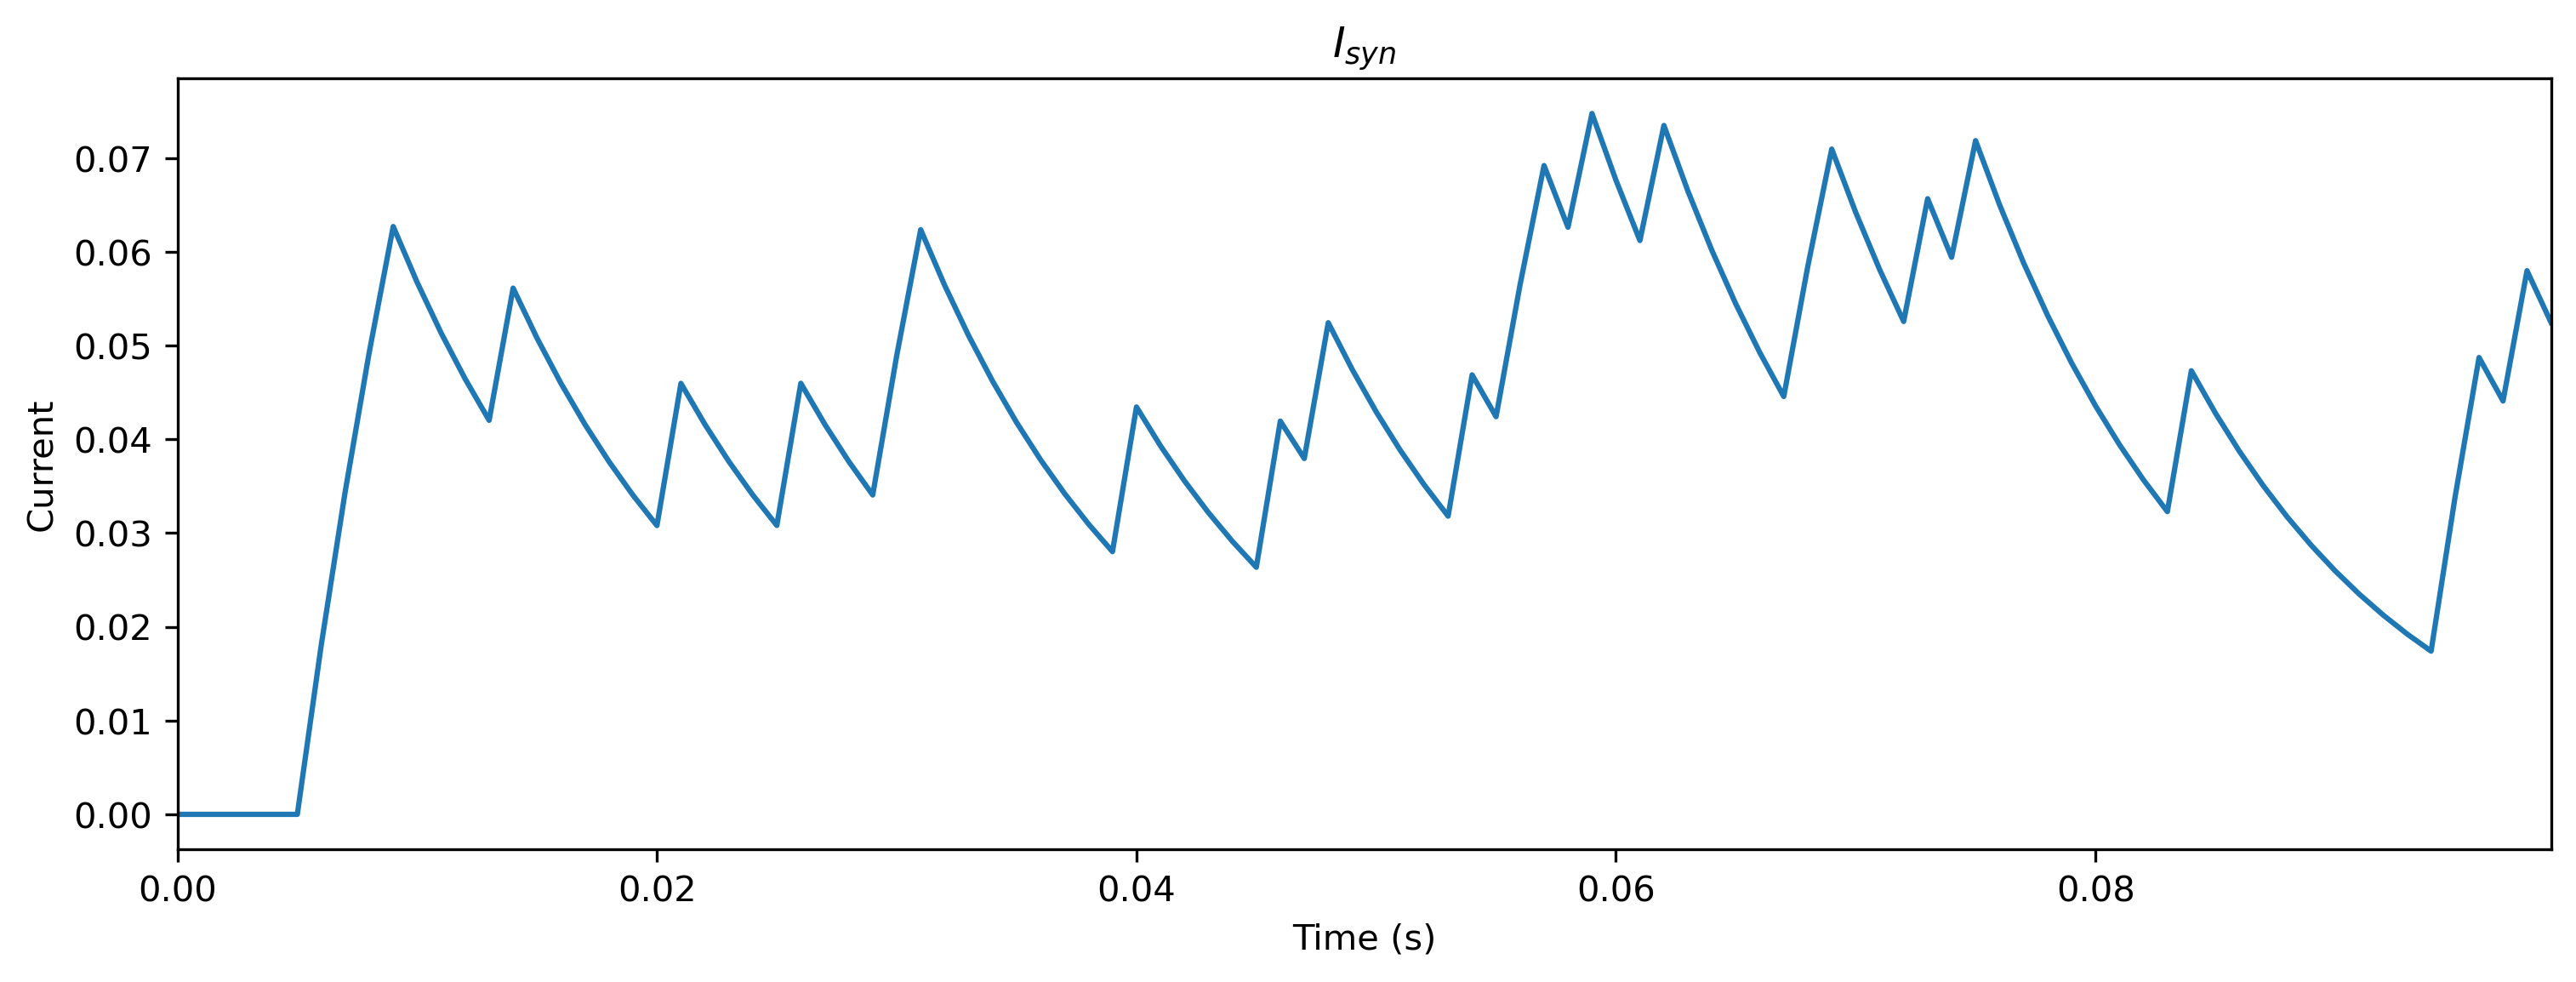

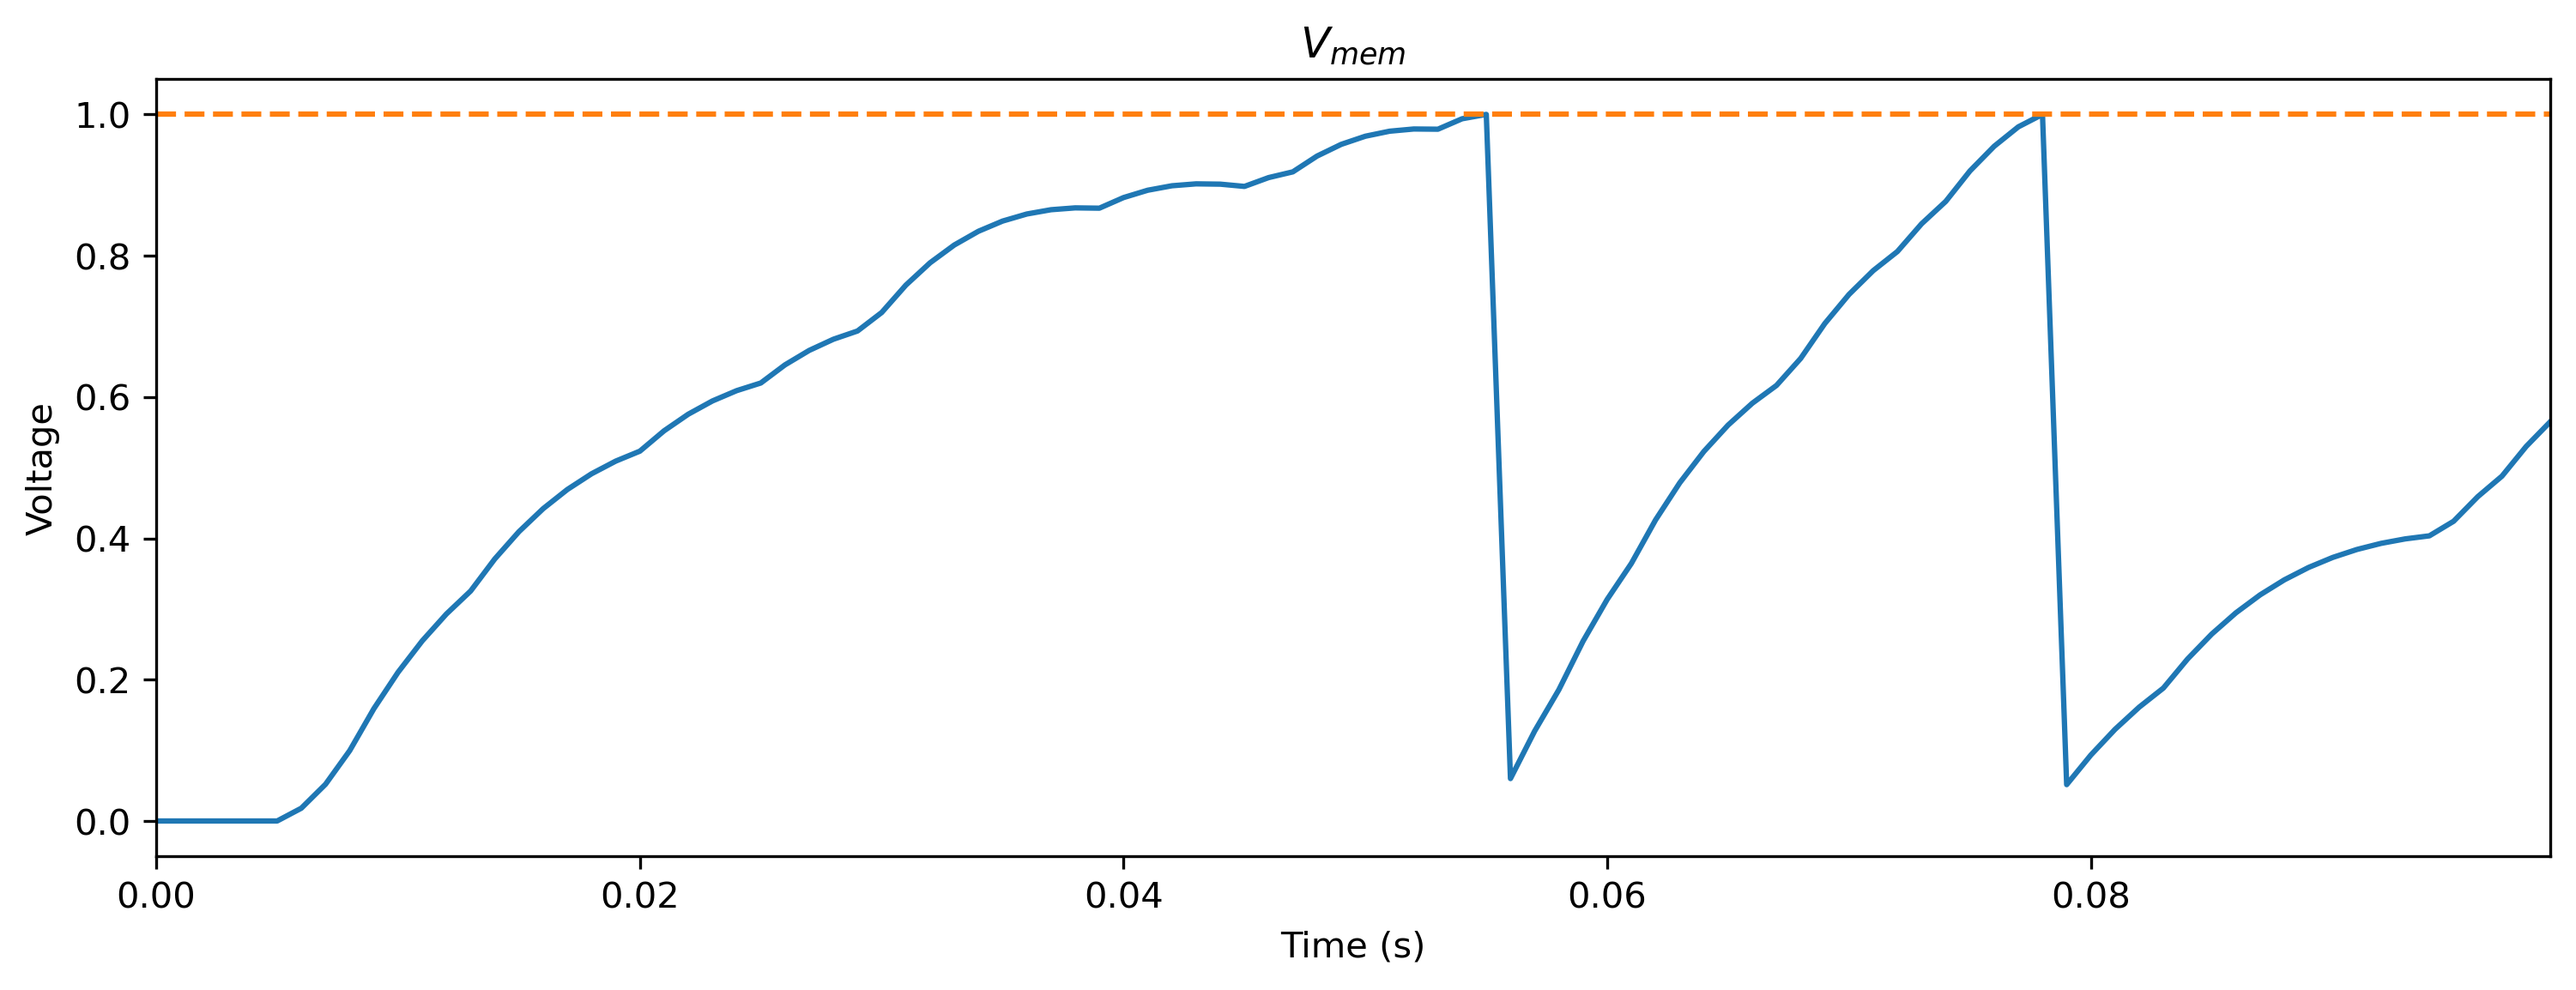

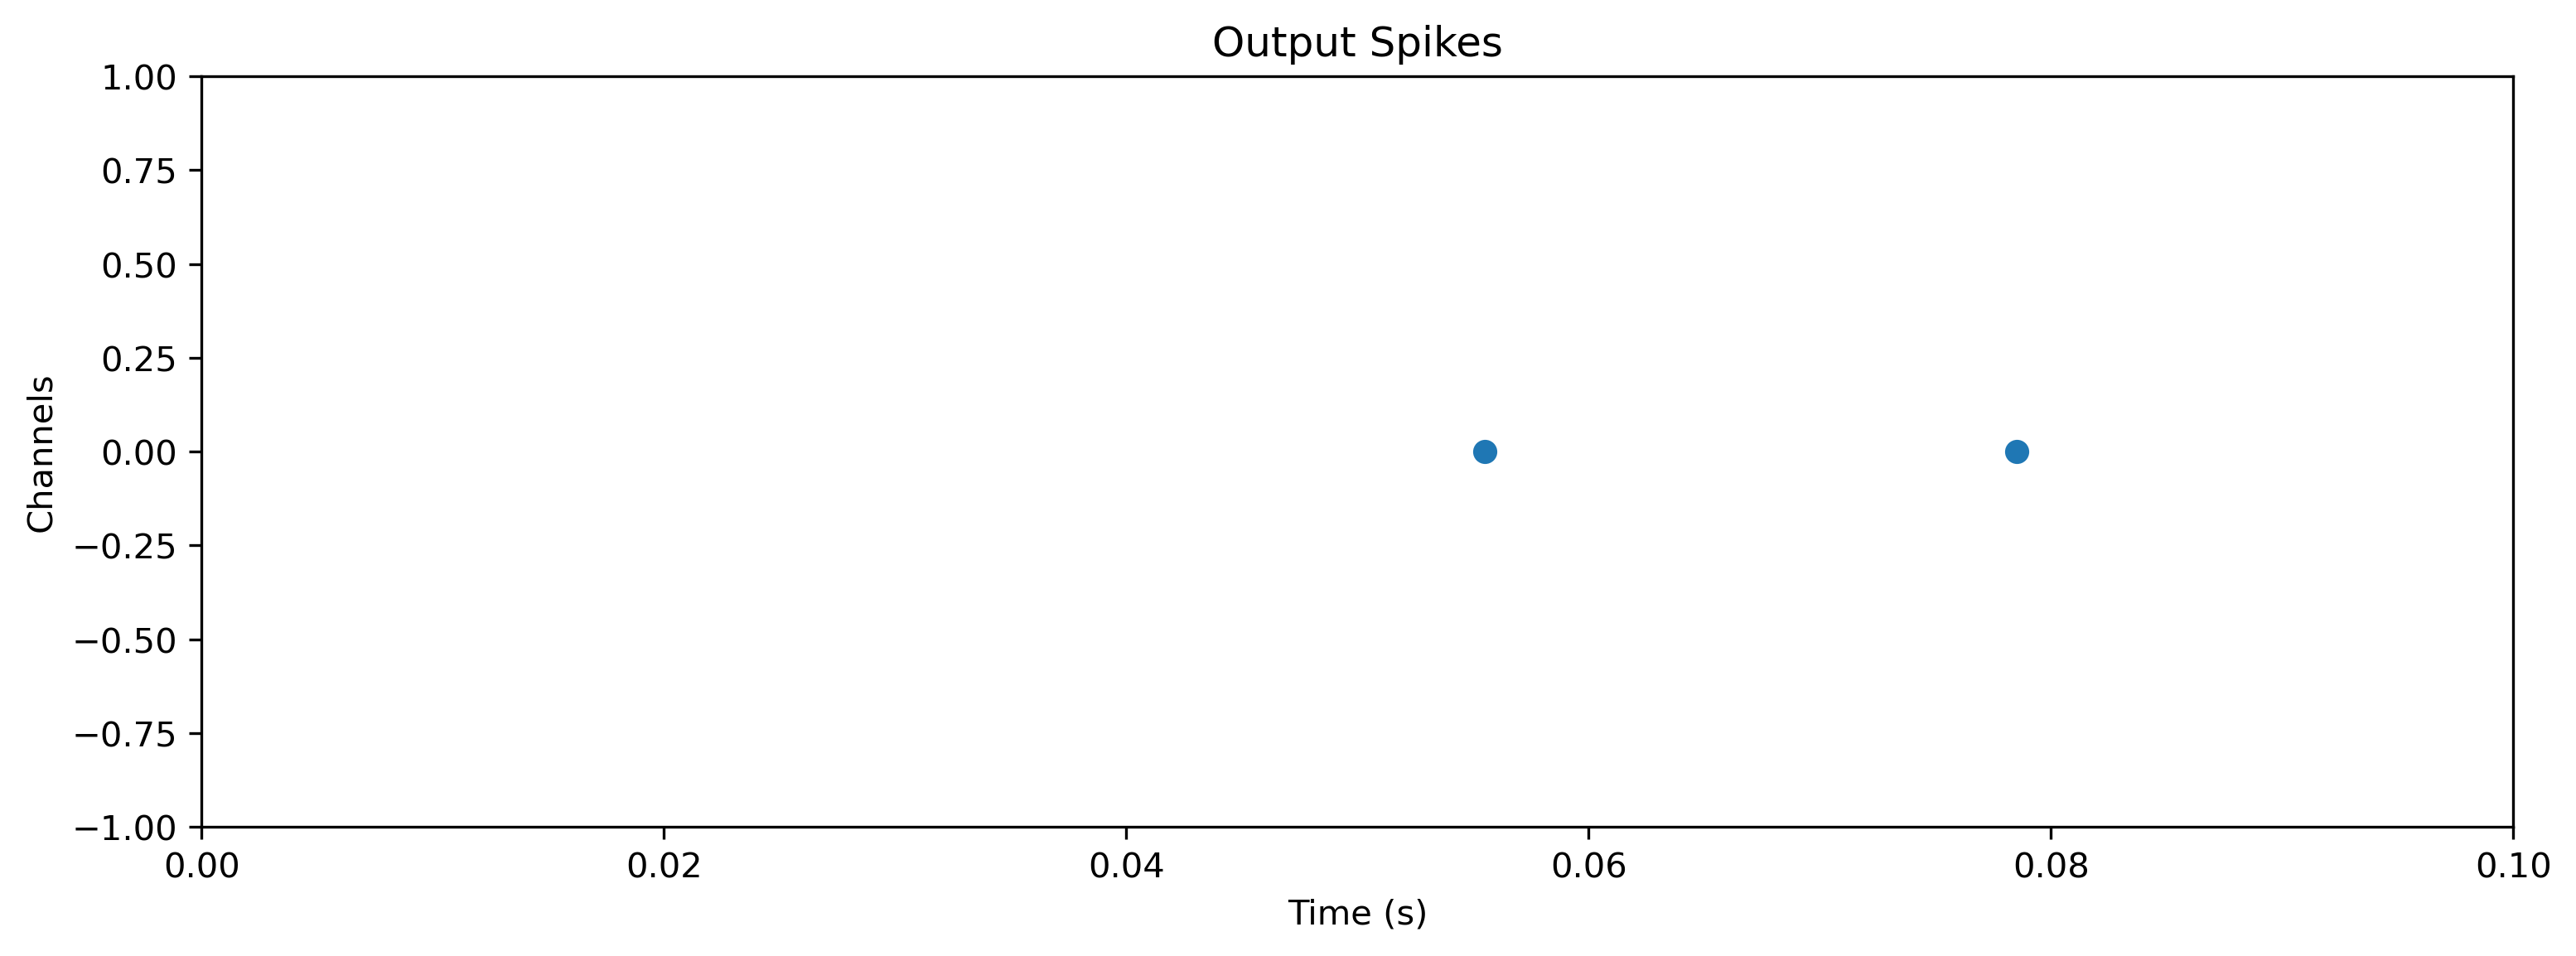

In [11]:
plot_LIF_record(record_dict['1_LIFTorch'], threshold=1.0)

2 spikes in 100 ms makes 20 Hz

In [12]:
print(rate_out)

tensor(20., grad_fn=<DivBackward0>)


---
## Section 2: Define the Task

We want the network to express a certain firing rate

In [50]:
target = torch.tensor(50.0)

### Loss Function

Here we're using mean square error (MSE) loss. 

MSE Loss : $ l = (r - \hat{r})^ 2 $

Let's investigate the loss function with respect to different rate readings

In [67]:
crit = MSELoss()
loss_trace = []

# Sweep over the rate values
R = np.linspace(0, target.item()*2, 100)
for _r in R:
    _loss = crit(torch.tensor(_r), target)
    loss_trace.append(_loss)

We see that the loss exponentially increases while the rate wander away from the target rate

Text(0.5, 0, 'Firing rate (Hz)')

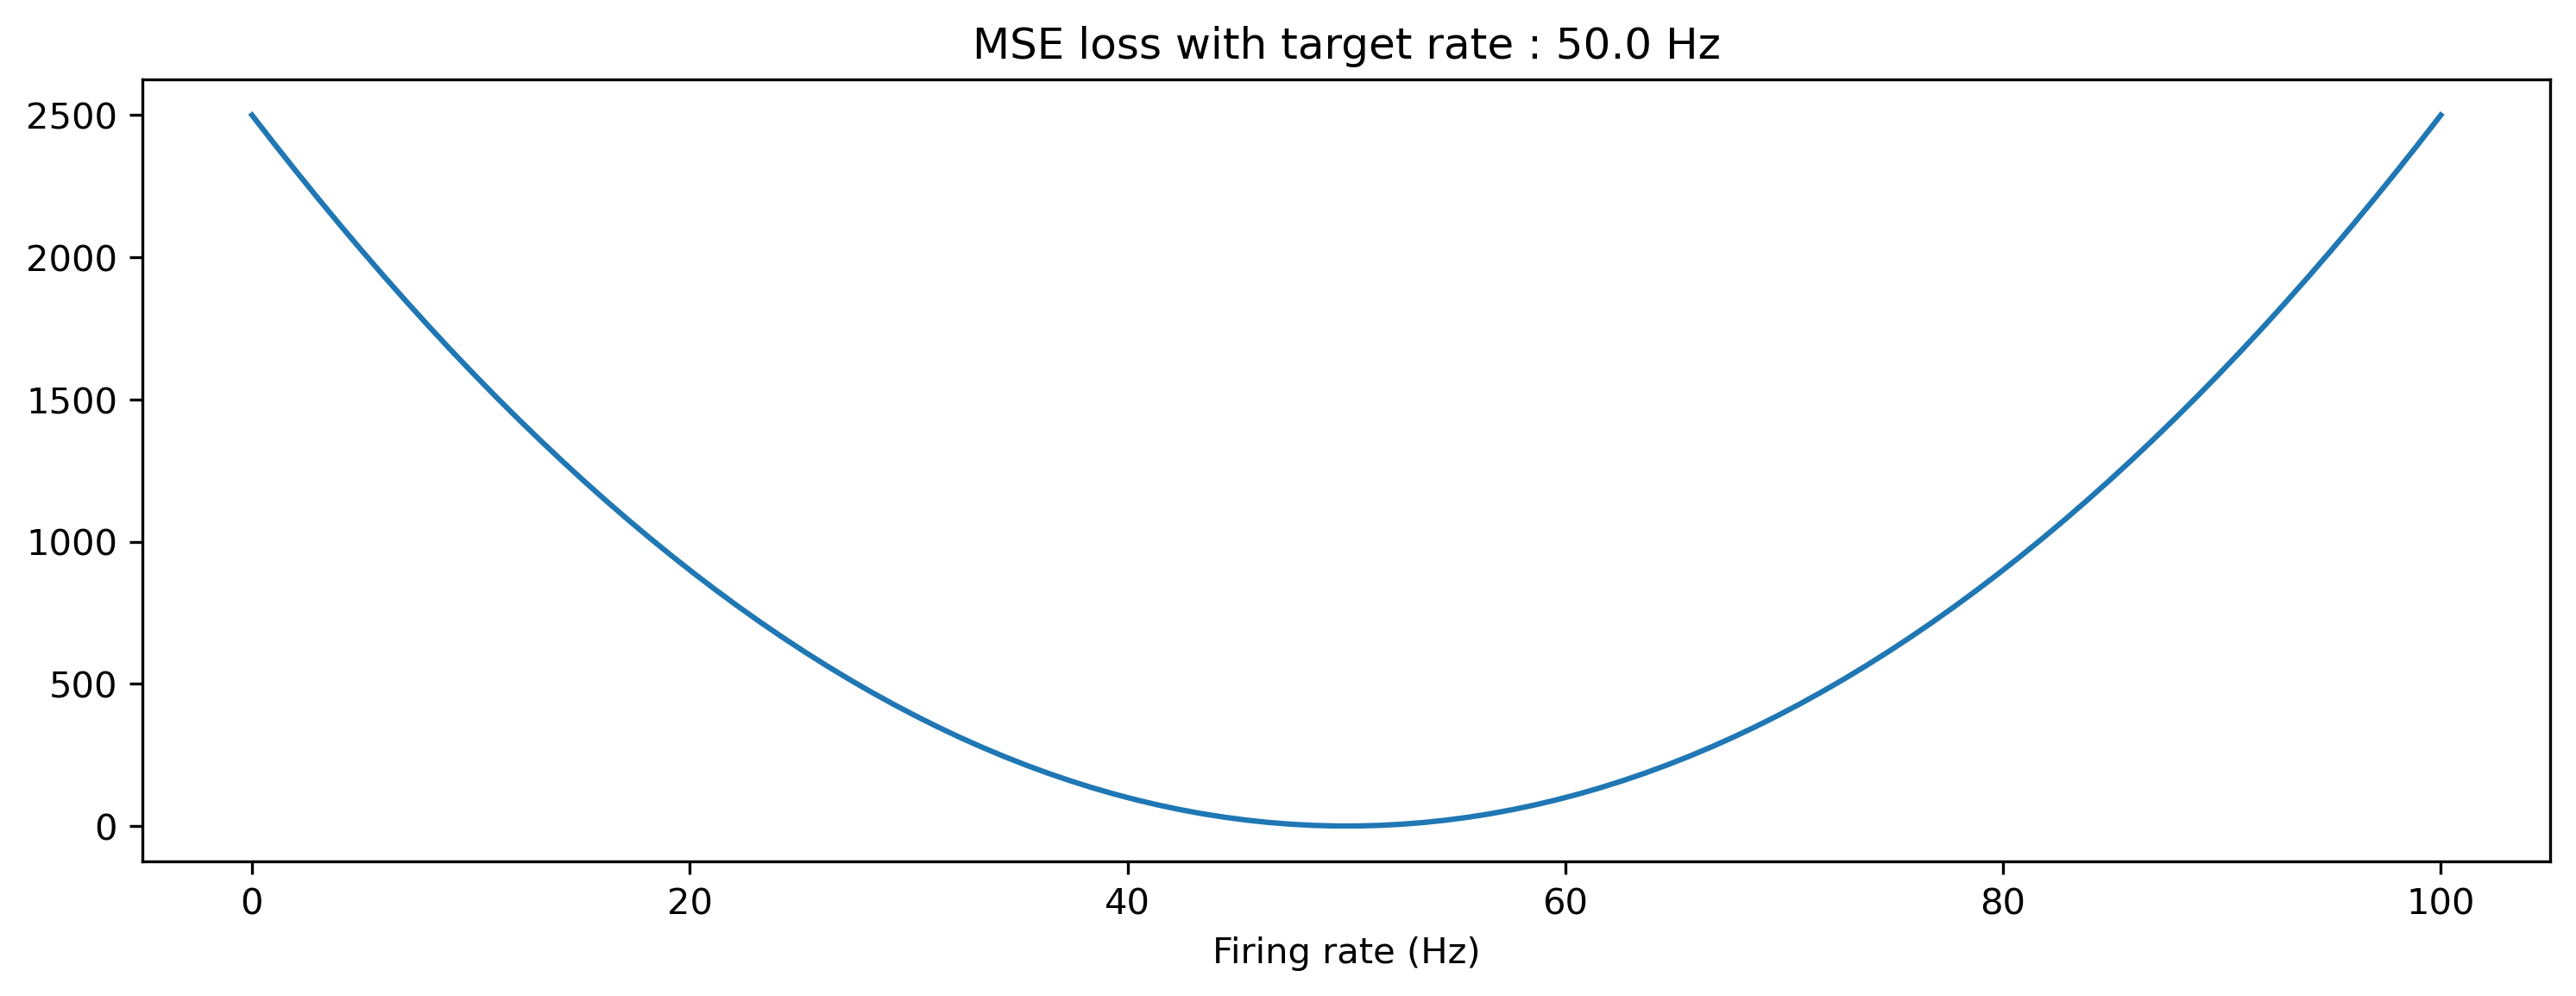

In [66]:
plt.figure()
plt.plot(R, loss_trace)
plt.title(f"MSE loss with target rate : {target.item()} Hz")
plt.xlabel("Firing rate (Hz)")

Now let's investigat the loss surface with respect to input weight

Text(0.5, 0, 'Input Weight')

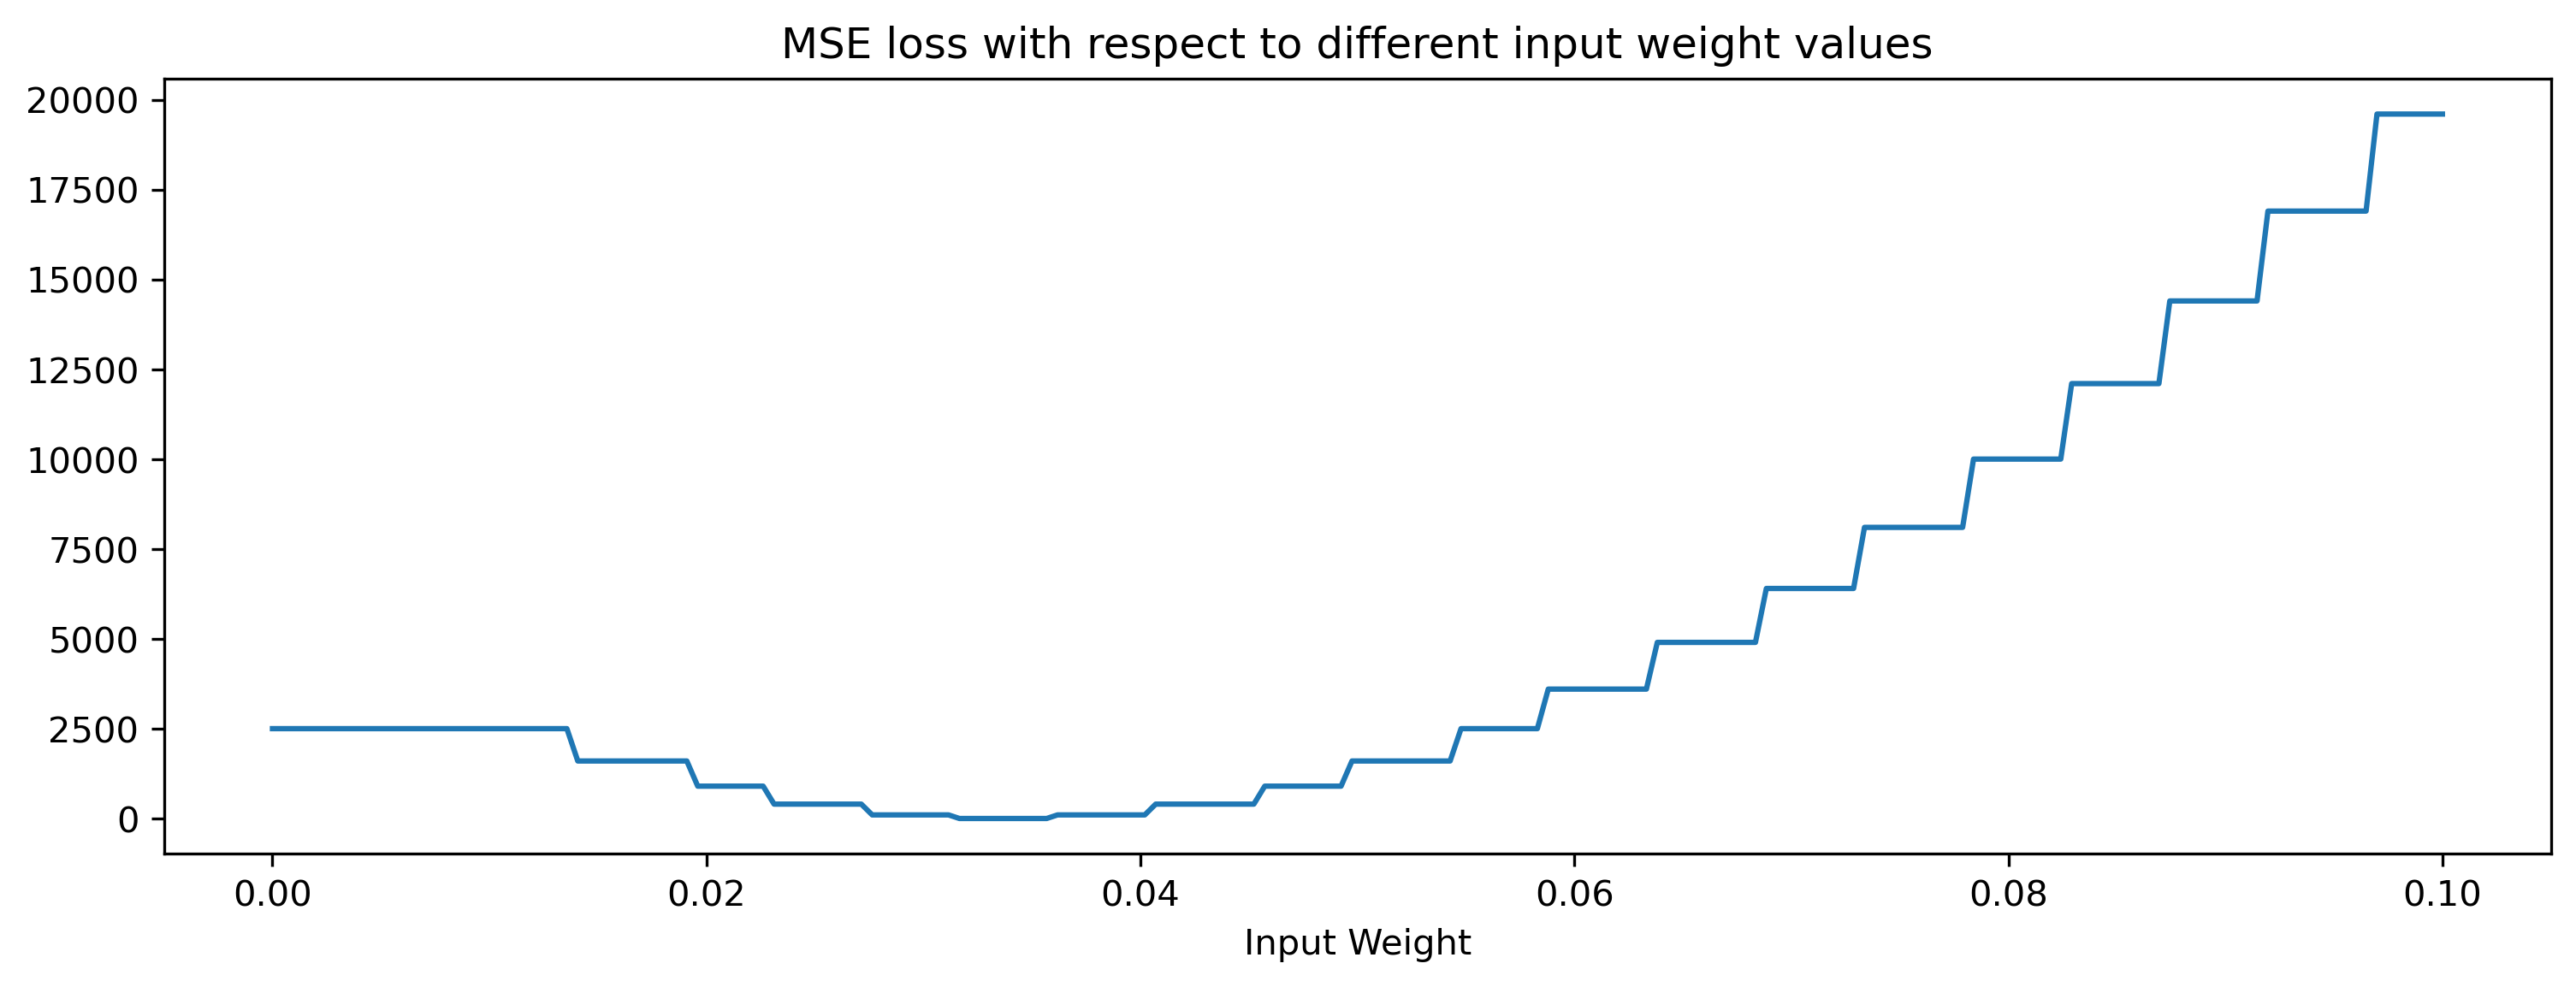

In [72]:
loss_trace = []
grad_trace = []
rate_trace = []

W = np.linspace(0, .1, 200, dtype=np.float32)

# Sweep over the weights
for w in W:
    # Redefine the model with a different input weight
    lin = LinearTorch((1, 1), weight = torch.tensor([[w]]), has_bias=False)
    model = Sequential(lin, lif, readout)

    # Simulate the network exactly with the same input
    model.reset_state()
    out, _, _ = model.evolve(spike_ts, record=True)
    rate_trace.append(out.item())
    
    # Calculate and record the loss
    loss = crit(target, out)
    loss_trace.append(loss.item())

    # Error backpropagation
    # loss -> readout -> lif -> linear         
    loss.backward()    
    grad_trace.append(model[0].weight.grad.item())

# Plot
plt.figure()
plt.plot(W, loss_trace)
plt.title("MSE loss with respect to different input weight values")
plt.xlabel("Input Weight")

If we want to apply a gradient based optimization technique to this problem

1. Initialize the weight with a random value
2. Compute the gradient of the loss with respect to weight
3. Slightly move to the opposite direction to the gradient
4. Repeat this until the process converges, and minimum loss achieved

However, you can see from the loss surface that gradients are 0 almost everywhere

## Section 2: Surrogate Gradients

`U = sigmoid(vmem * 20.0, self.threshold)` ???

* Remember from the monday session that

We choose a transfer function that produces events — basically, if the internal state is above a threshold $\theta$, the neuron produces a binary event on the output. We'll use a Heaviside function for that.

$$y = H(v, \theta) = v > \theta$$

`Heaviside Plot`

When a neuron sends an output, we reset $v$ by subtracting the threshold:

$$v = v - y * \theta$$

`Voltage decrease`

* Take the gradient and show it's not working
* Problem is derivative of the heaviside step function
* small change but big jump
* local minima is flat everywhere

<img src="figures/gradient_problem2.png" width="600">

* Solution

<img src="figures/surrogate_gradients.png" width="600">

* true gradient vs. surrogate gradient

* MAYBE SHOW THE LOSS COMPUTATION WITH TRUE GRADIENTS VS. SURROGATE GRADIENTS AFTER THE TRAINING

<img src="figures/output.png" width="600">

MSE Loss : $ l = (r - \hat{r})^ 2 $

$ \nabla_w l = -2(\hat{r}-r) \times \nabla_w \hat{r} $

$ \nabla_w \hat{r} = - 0.5 \dfrac{\nabla_w l} {(\hat{r}-r)}$

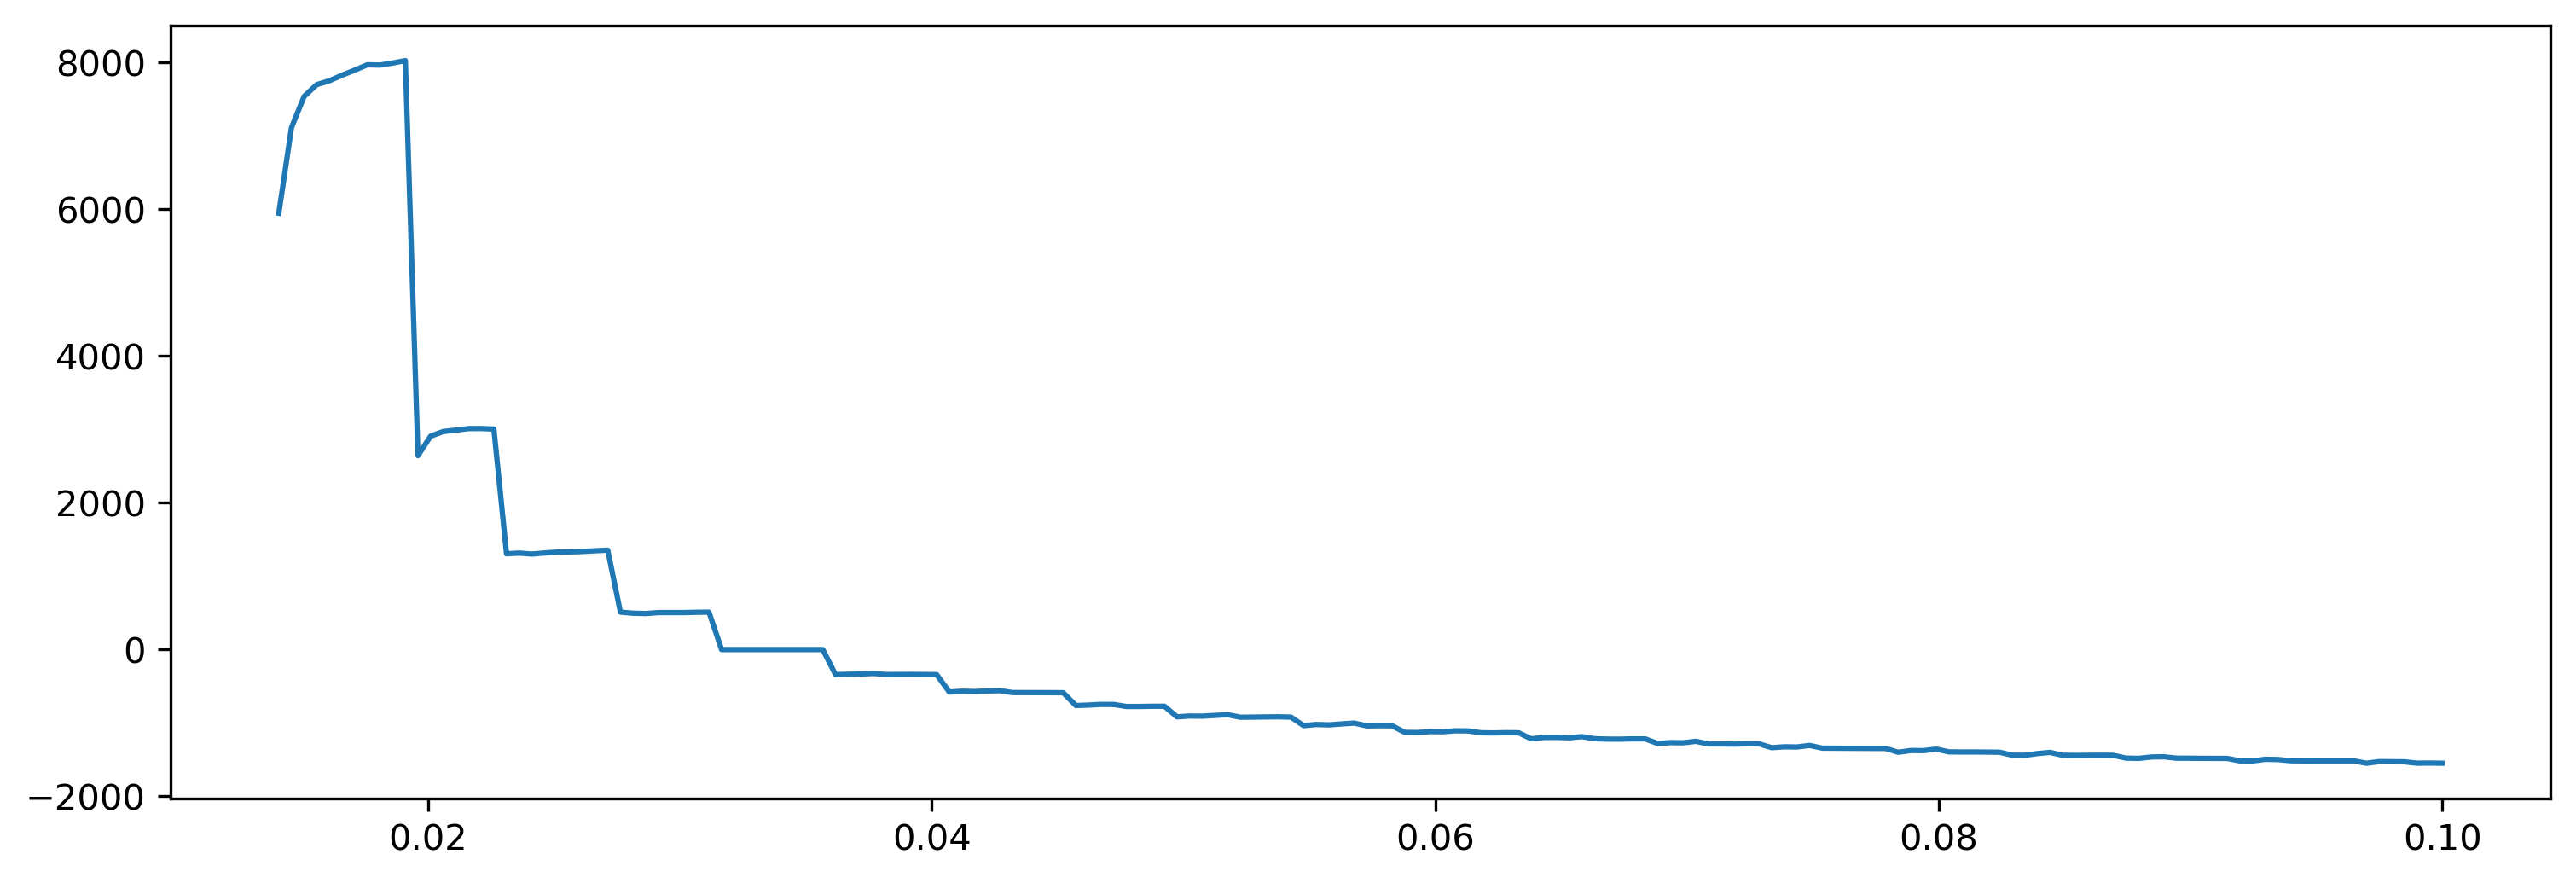

In [17]:
rate_diff = float(tgt) - np.array(rate_trace)
plt.figure()
plt.plot(W, -0.5*(np.array(grad_trace)/np.array(rate_trace)))

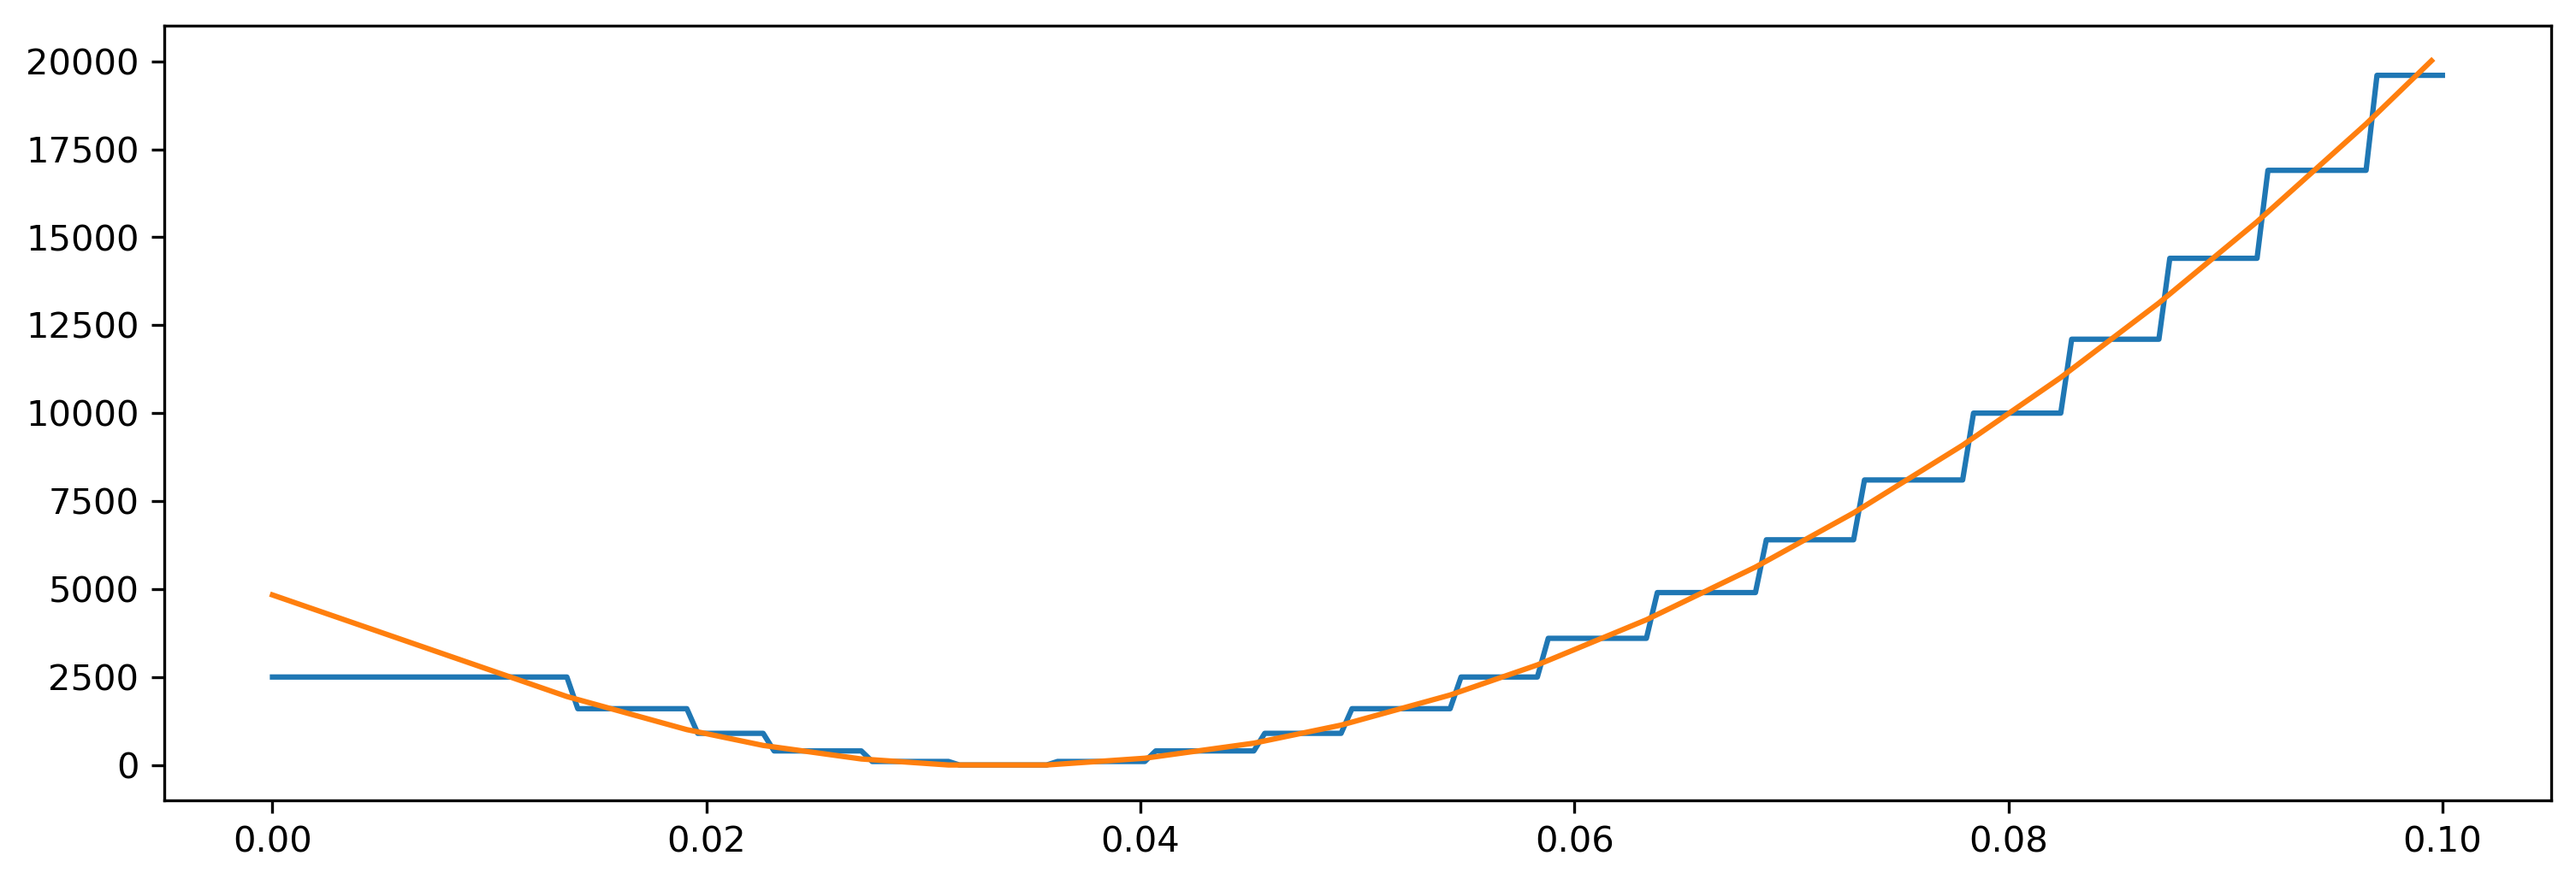

In [ ]:
original_function = np.cumsum(np.array(grad_trace)[:-1].flatten()*np.diff(W.flatten()))
cum_sum_grad = np.cumsum(grad_trace)
original_function = original_function - np.min(original_function) + np.min(loss_trace)

original_function = original_function - np.min(original_function) + np.min(loss_trace)

# plt.plot(W[:-1], original_function)
# plt.plot(W[:-1], loss_trace[:-1])
plt.figure()
plt.plot(W, loss_trace)
plt.plot(W[:-1], original_function)

## Section 3 : Training a Spiking Neural Network

In [34]:
# Reinitialize the network

dt = 1e-3

# --- Input Layer --- #
linear = LinearTorch(
    shape=(1, 1),
    has_bias=False,
)

# --- LIF Layer --- #
lif = LIFTorch(
    shape=(1, 1),
    tau_mem=Constant(0.03),
    tau_syn=Constant(0.01),
    bias=Constant(0.0),
    threshold=Constant(1.0),
    spike_generation_fn=StepPWL,
    dt=dt,
)

# --- Readout Layer --- #
readout = RateReadout(shape=(1, 1), dt=dt)

# --- Model --- #
model = Sequential(linear, lif, readout)
model

TorchSequential  with shape (1, 1) {
    LinearTorch '0_LinearTorch' with shape (1, 1)
    LIFTorch '1_LIFTorch' with shape (1, 1)
    RateReadout '2_RateReadout' with shape (1, 1)
}

In [35]:
crit = MSELoss()
optim = Adam(model.parameters().astorch(), lr=1e-2)
param_trace = []
loss_trace = []
grad_trace = []

for i in tqdm(range(1000)):
    model.reset_state()
    optim.zero_grad()
    out, state, rec = model.evolve(spike_ts, record=True)
    
    # Calculate rate here
    loss = crit(tgt, out)
    loss_trace.append(loss.item())
    
    if loss == 0:
        break
        
    loss.backward()
    optim.step()
    
    param_trace.append(model._modules['0_LinearTorch'].weight.data[0, 0].item())
    grad_trace.append(model._modules['0_LinearTorch'].weight.grad[0, 0].item())

 18%|█▊        | 179/1000 [00:08<00:38, 21.10it/s]


## Section 4 : Analyzing the Results

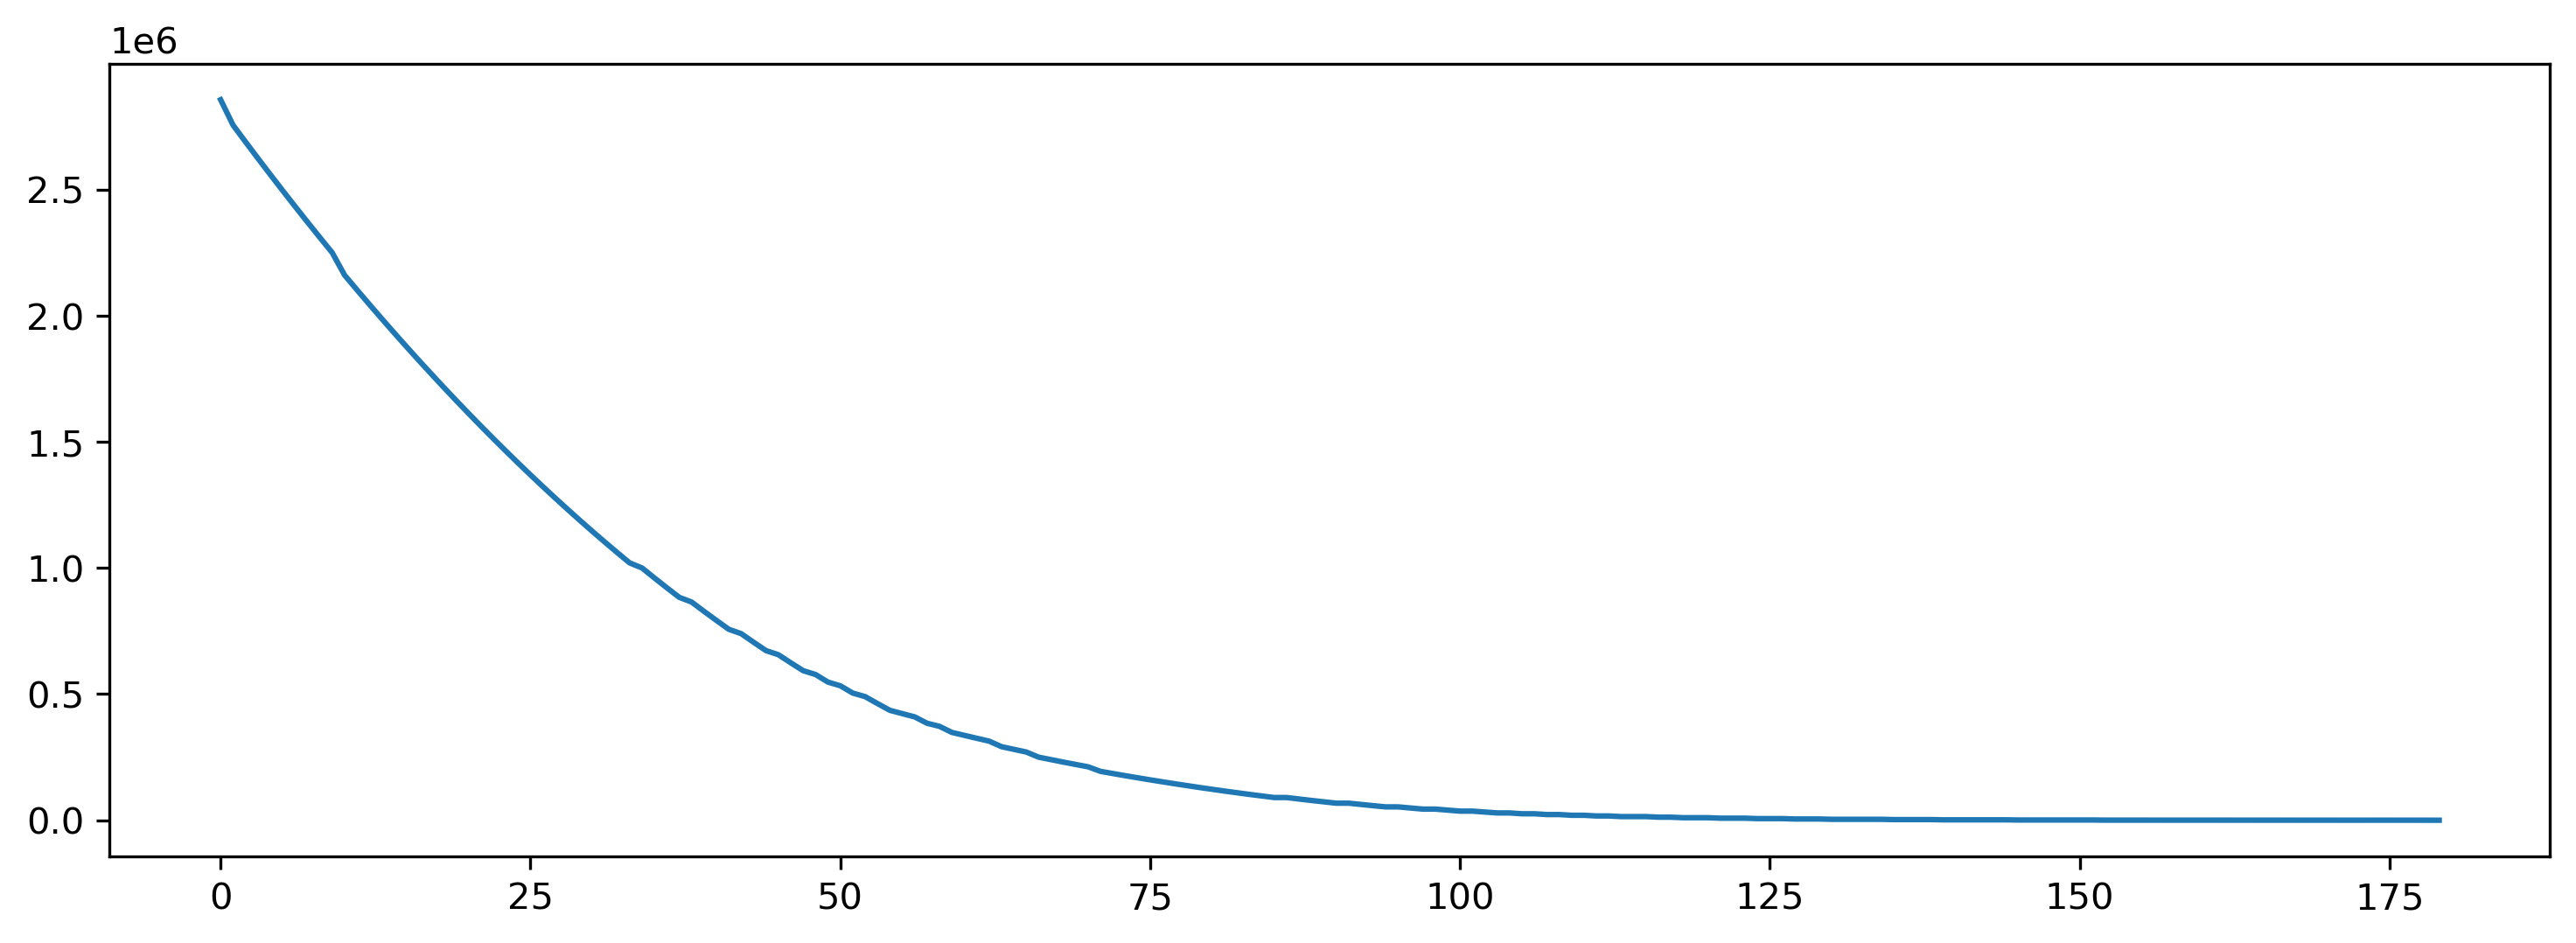

In [39]:
plt.plot(loss_trace)
# plt.yscale("log")

In [40]:
modIn = model[0]
modLIF = model[1]

In [41]:
# Explore tau and weight change

In [42]:
model.reset_state()
out, state, rec = model(spike_ts, record=True)

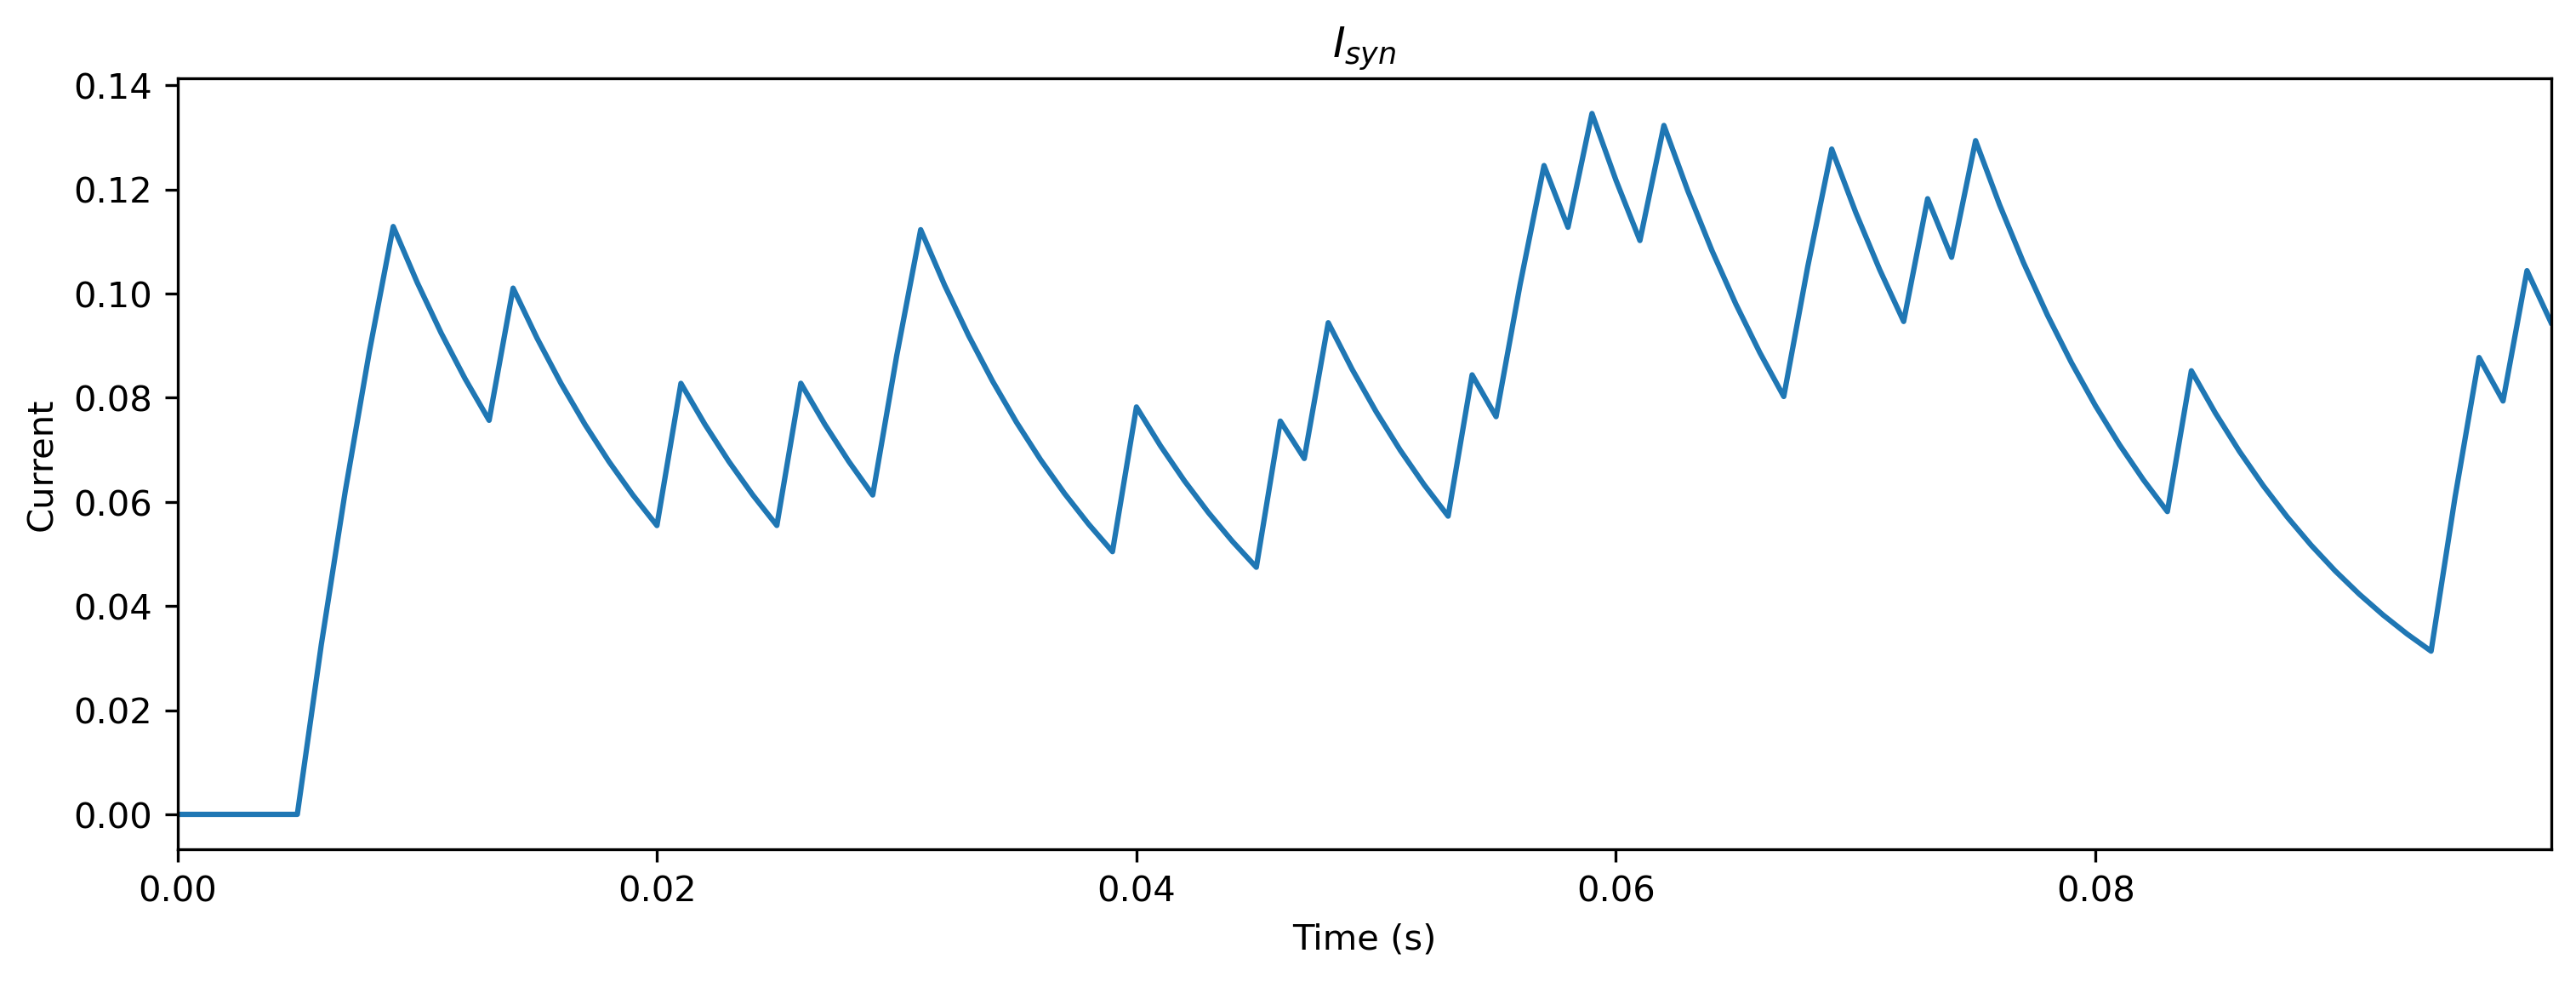

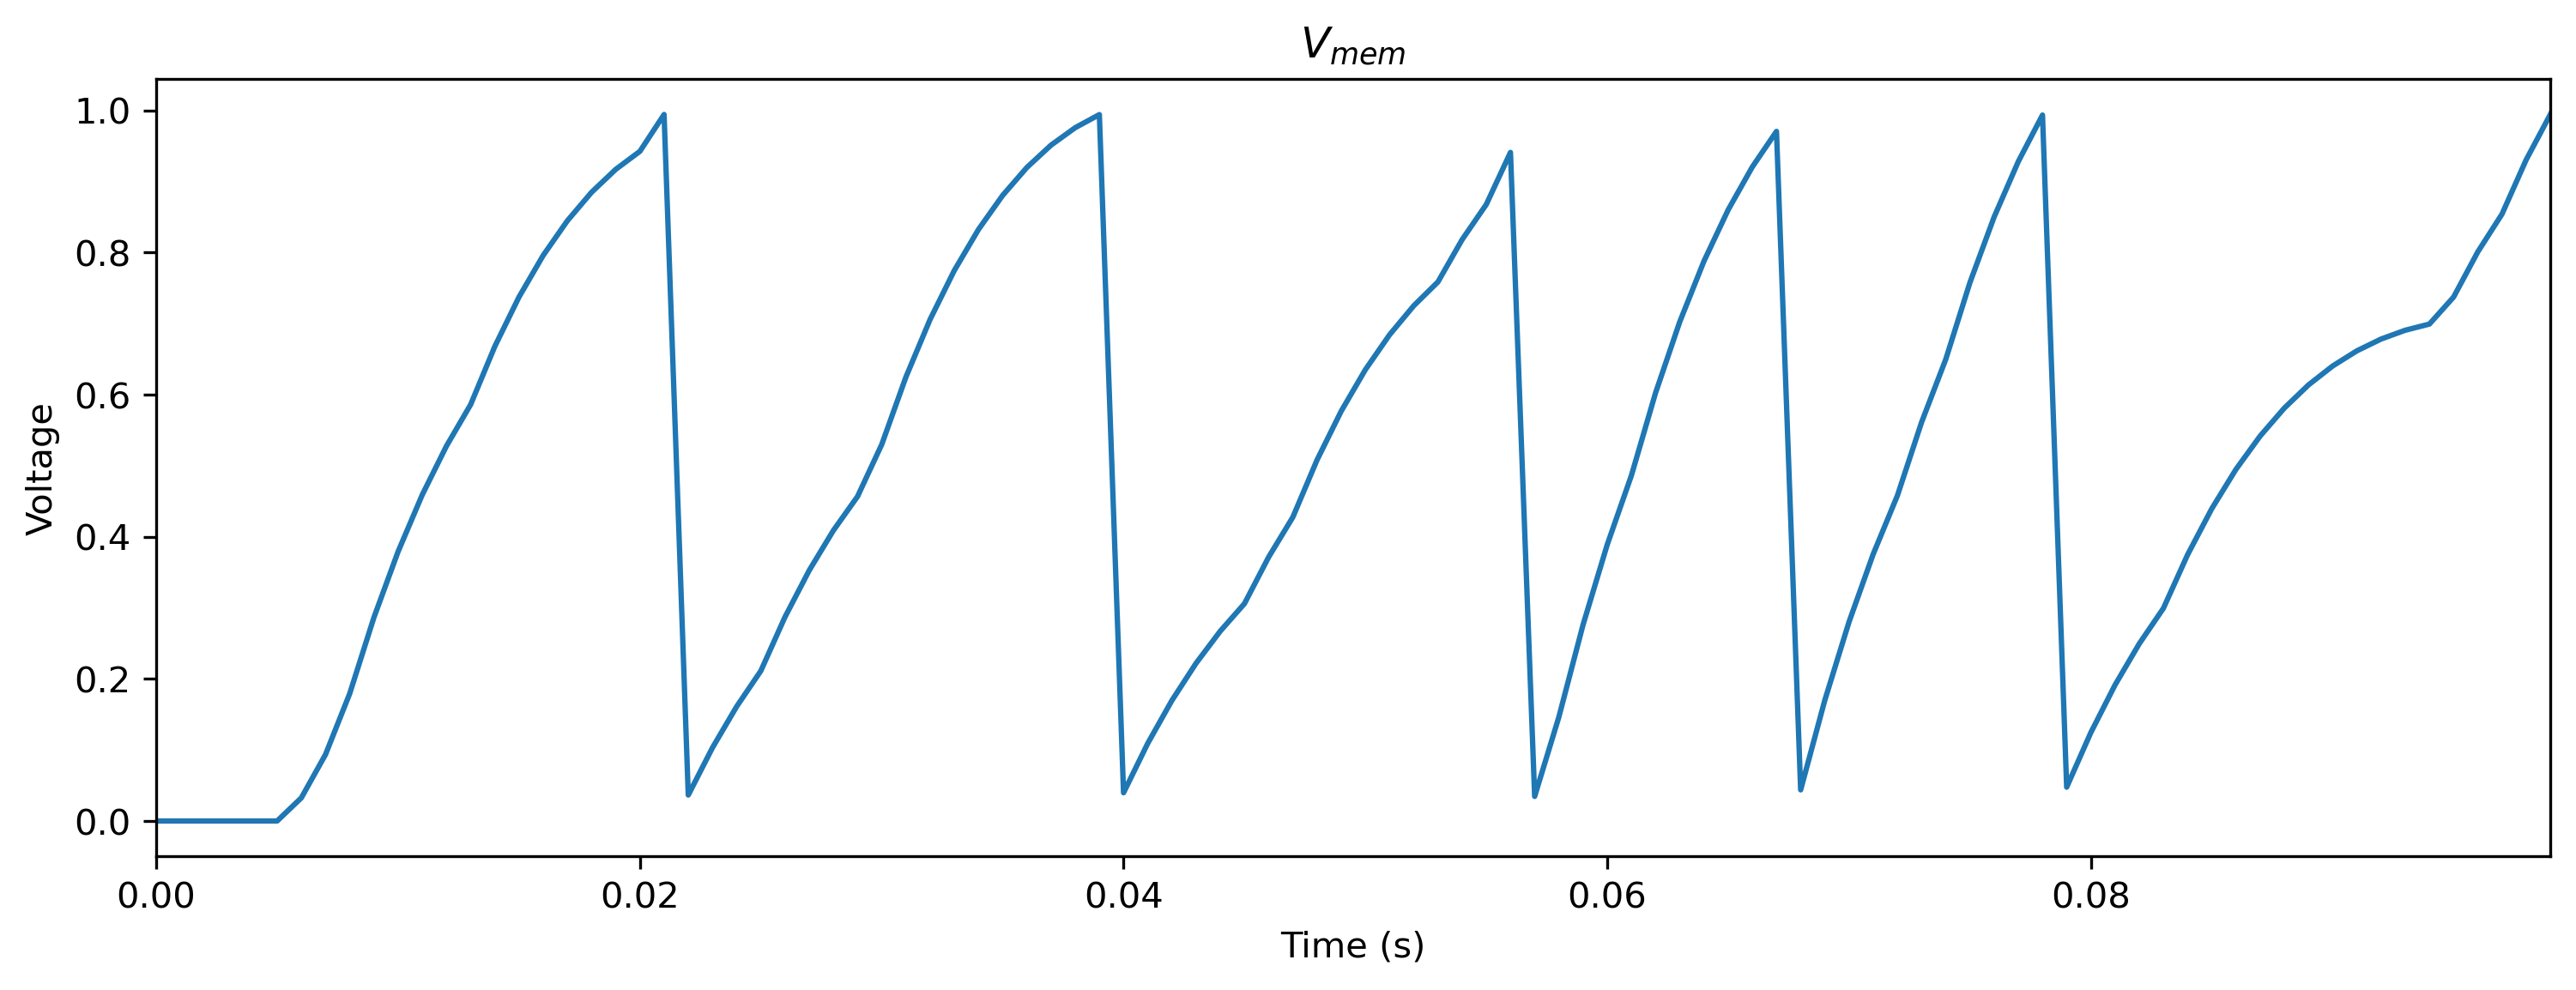

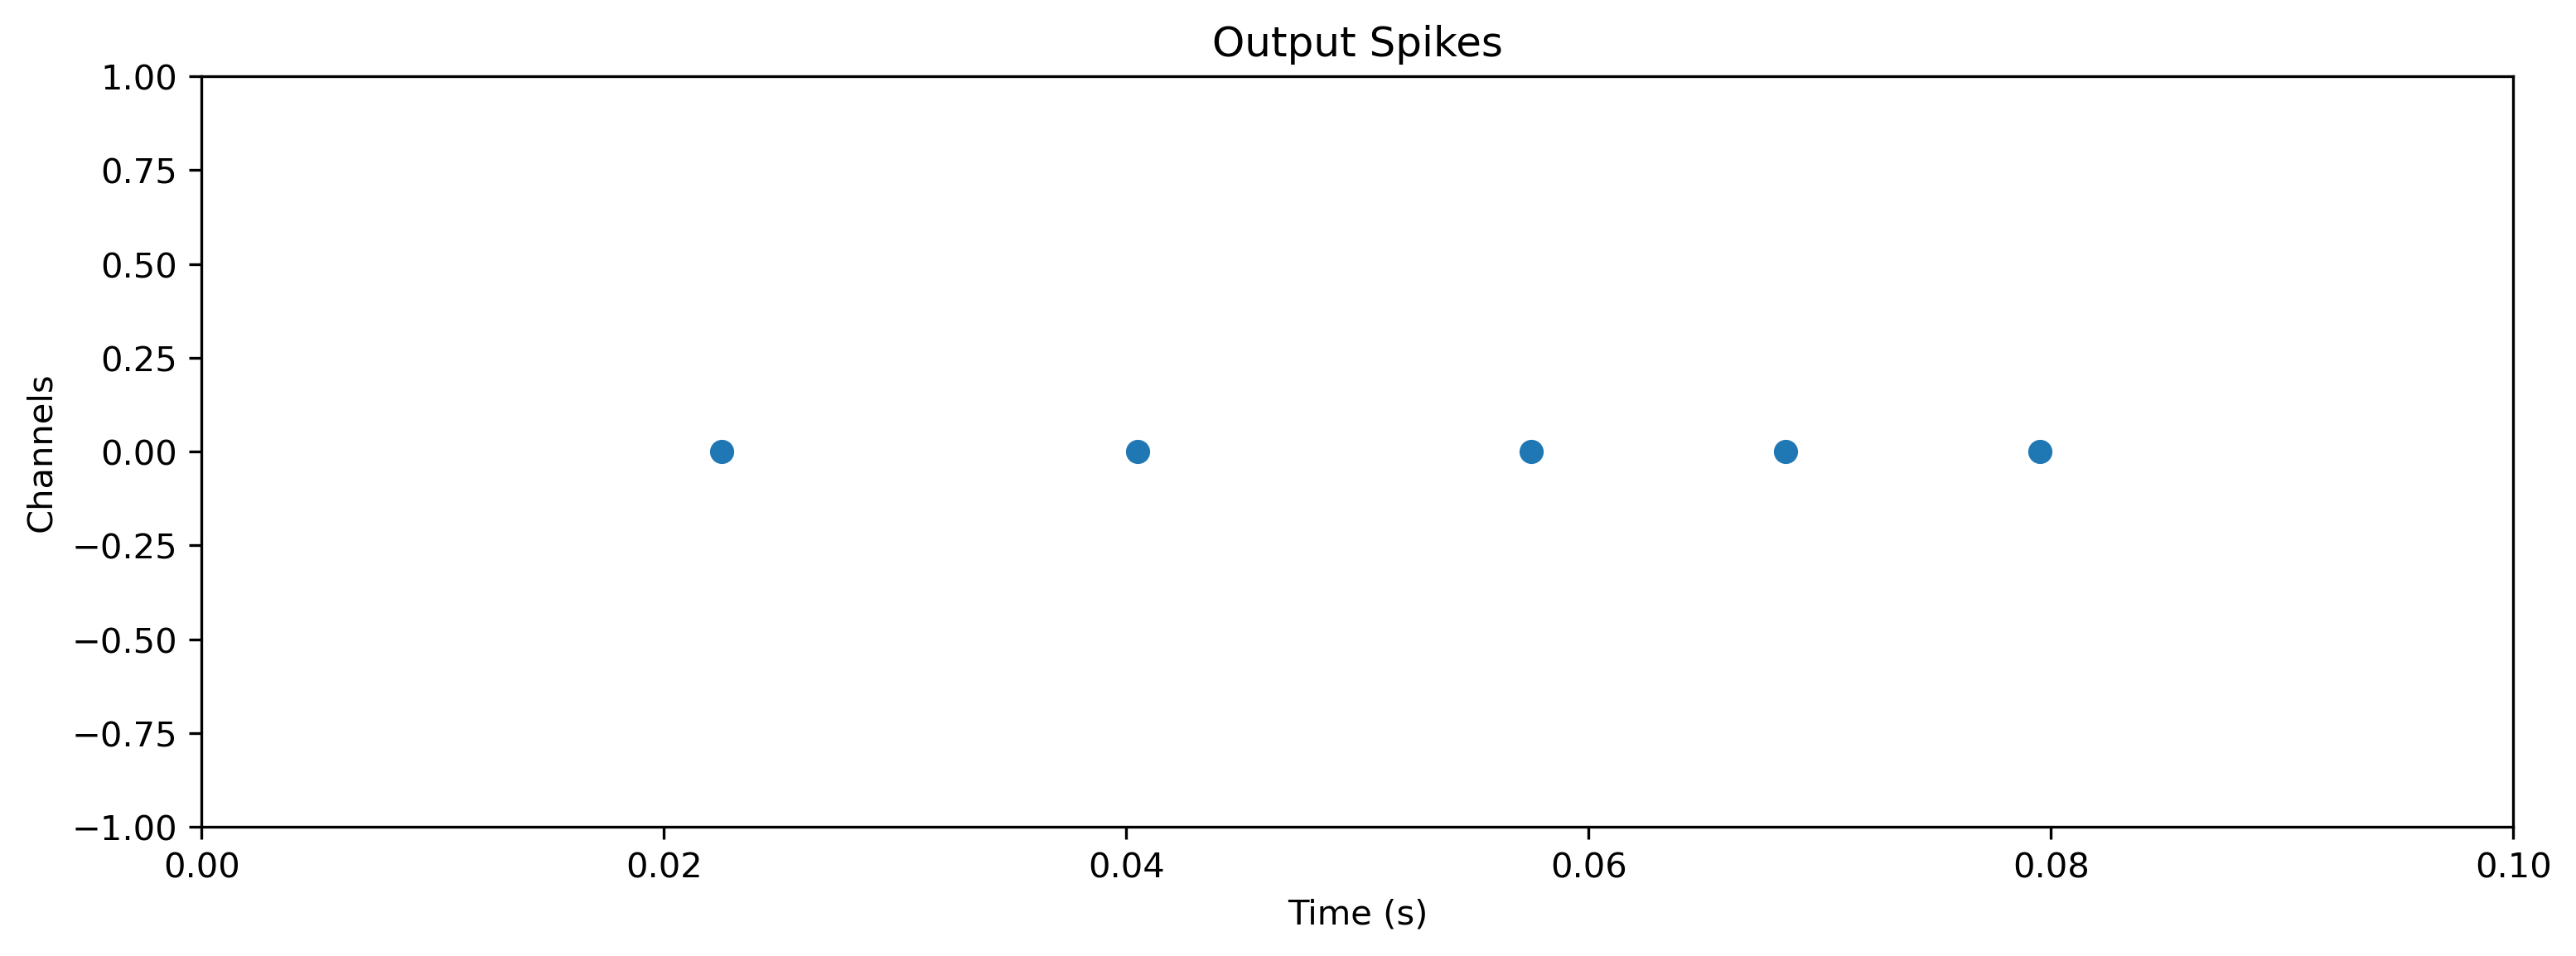

In [43]:
plot_LIF_record(rec['1_LIFTorch'])